In [ ]:
!pip install ndlib

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ***CELL TO CHECK IF YOUR DATA IS CORRECT***

In [ ]:
import pandas as pd
import networkx as nx

# Carica il file CSV
file_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
df = pd.read_csv(file_path)

# Crea il grafo non pesato e non orientato
df_unweighted = df[['author1', 'author2']].drop_duplicates()
crawled_graph = nx.from_pandas_edgelist(df_unweighted, 'author1', 'author2')

# Verifica il numero di nodi
num_nodes = crawled_graph.number_of_nodes()
print(f"\nNumero di nodi nel grafo: {num_nodes}")

if num_nodes == 19549:
    print("Il numero di nodi è corretto! Il problema deve essere altrove")
else:
    print(f"Il numero di nodi è errato! N = {num_nodes}")



Numero di nodi nel grafo: 19549
Il numero di nodi è corretto! Il problema deve essere altrove


# Random Strategy

proportion with 0.05

Simulating on Crawled graph with random strategy...


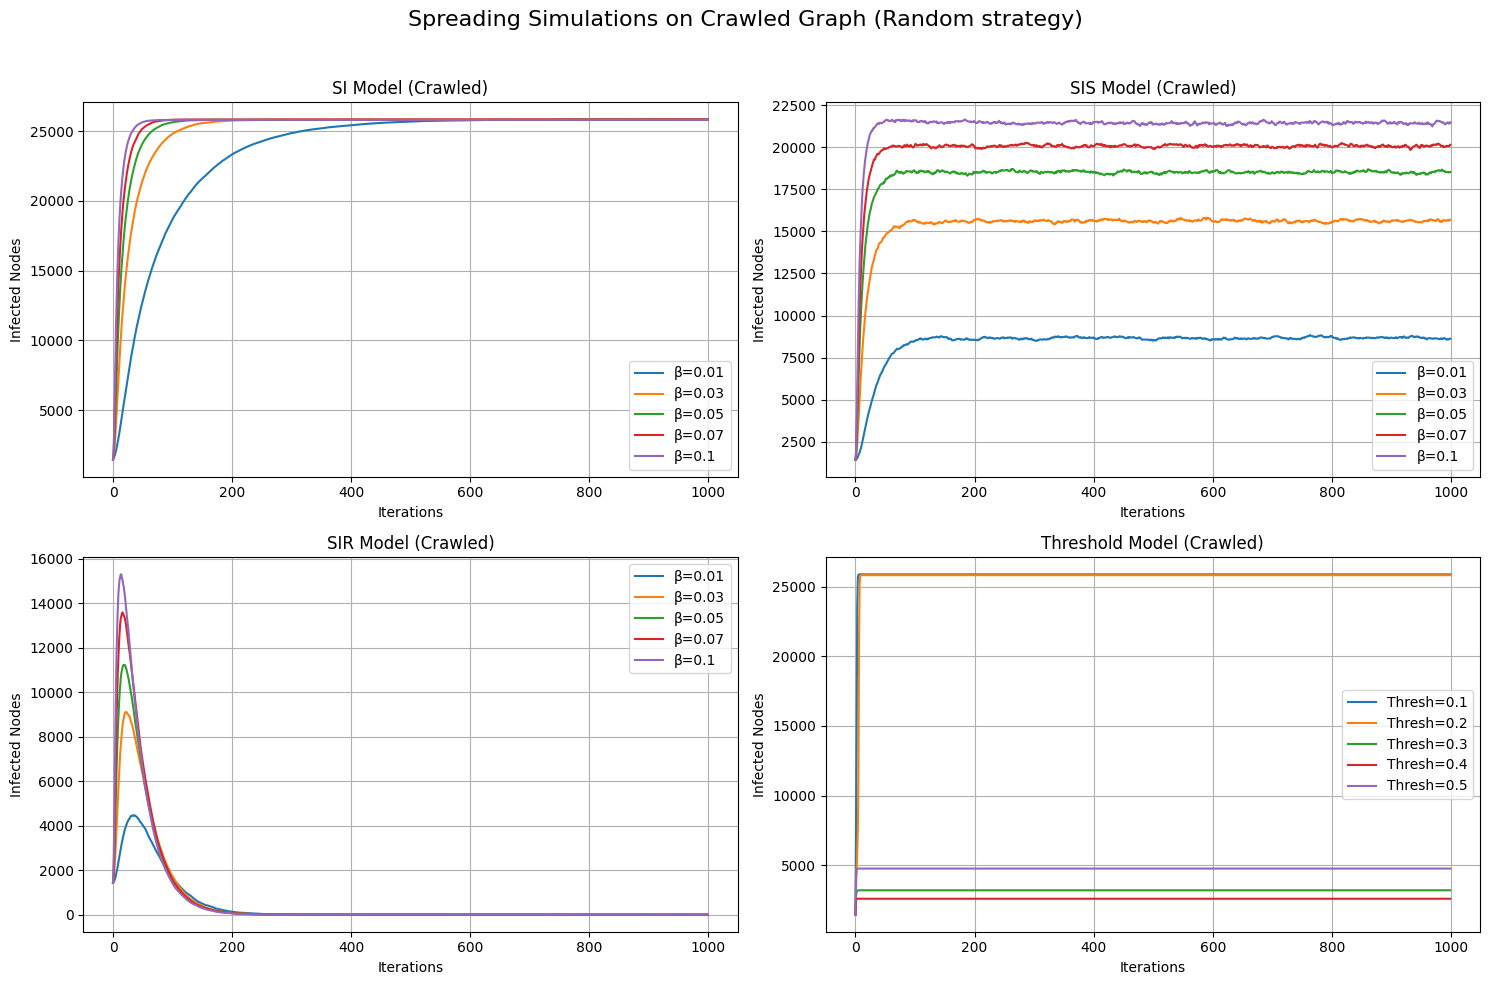

Simulating on Erdos-Renyi graph with random strategy...


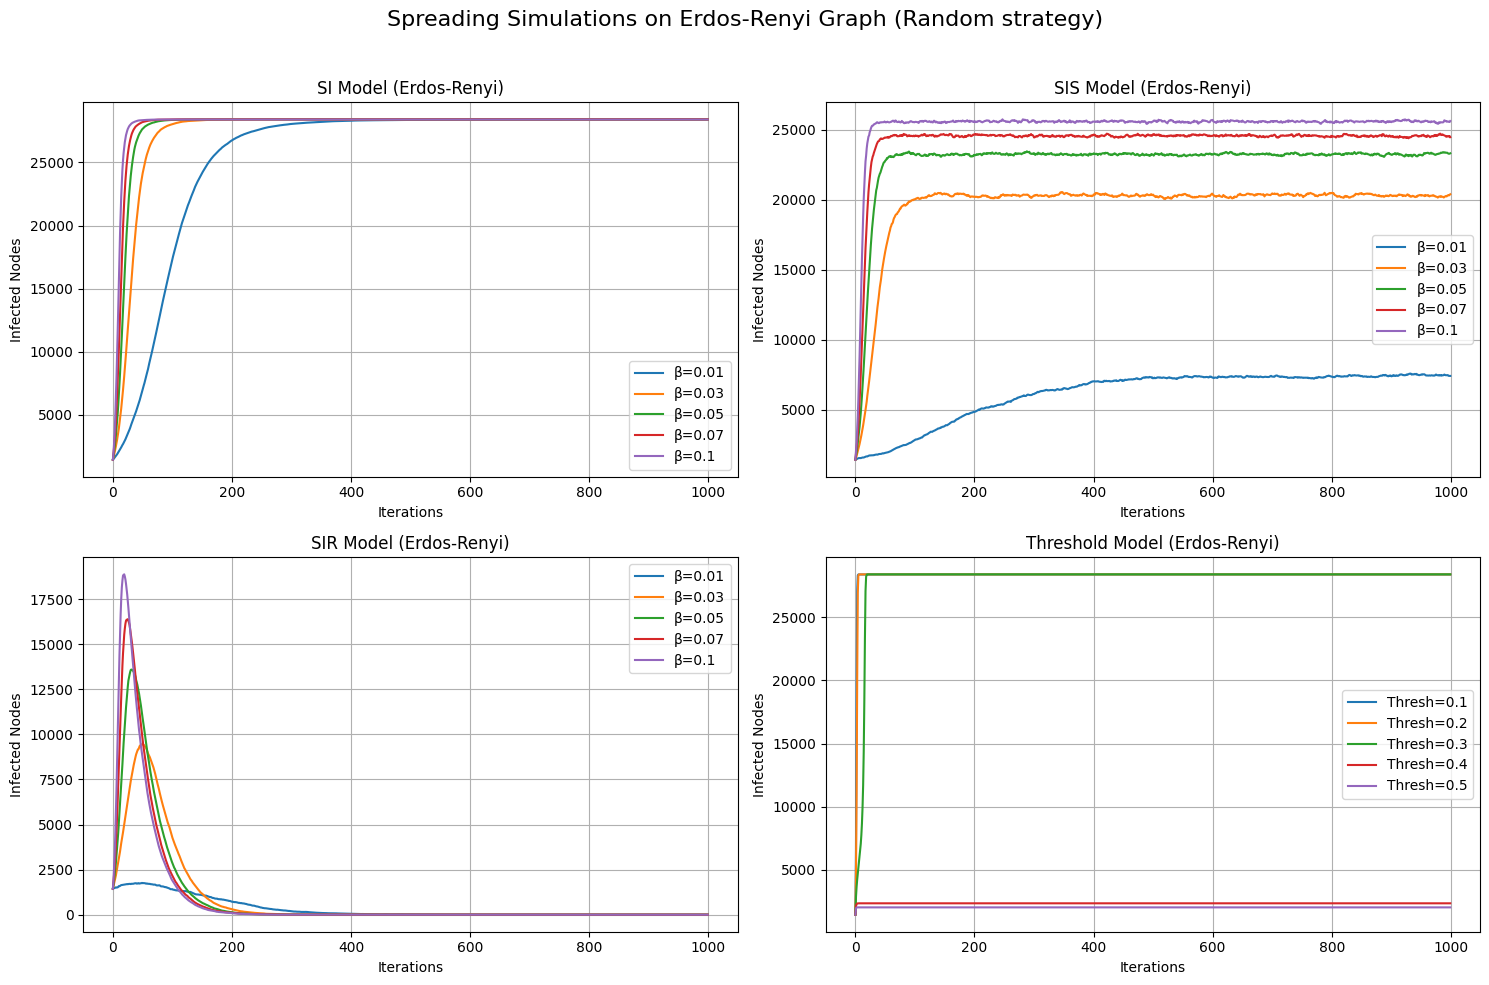

Simulating on Barabasi-Albert graph with random strategy...


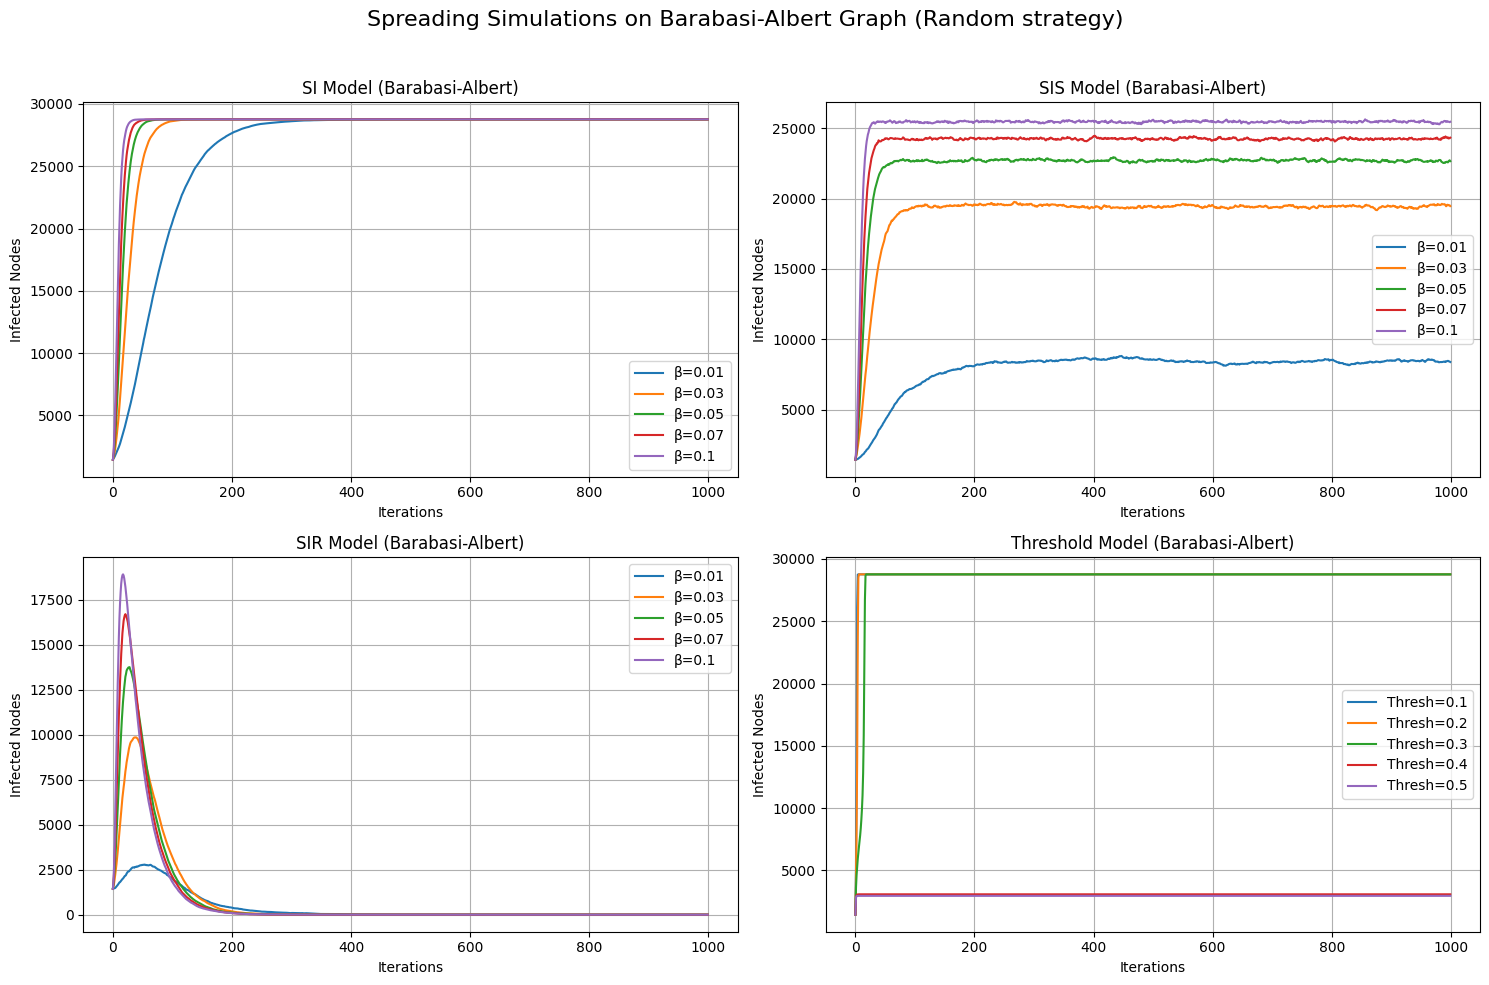

In [ ]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np


# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Generate comparable synthetic graphs
num_nodes = crawled_graph.number_of_nodes()
num_edges = crawled_graph.number_of_edges()
er_graph = nx.gnm_random_graph(num_nodes, num_edges)
ba_graph = nx.barabasi_albert_graph(num_nodes, m=max(1, num_edges // num_nodes))

graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Parameters
beta_values = [0.01, 0.03, 0.05, 0.07, 0.1]
gamma_values = [0.01, 0.03, 0.05, 0.07, 0.1]
threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5]

def select_initial_infected(graph, proportion=0.05):
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=100):
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] for iteration in iterations]
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    for label, counts in results.items():
        ax.plot(counts, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Infected Nodes')
    ax.legend()
    ax.grid()

for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph with random strategy...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph (Random strategy)", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']
    iterations_dict = {'SI': 1000, 'SIS': 1000, 'SIR': 1000, 'Threshold': 1000}

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in threshold_values:
                infected_counts = simulate_model(
                    graph,
                    model_name,
                    beta=None,
                    gamma=None,
                    threshold=threshold,
                    iterations=iterations_dict[model_name],
                )
                label = f"Thresh={threshold}"
                results[label] = infected_counts
        else:
            for beta in beta_values:
                gamma = gamma_values[1] if model_name in ['SIS', 'SIR'] else None
                infected_counts = simulate_model(
                    graph,
                    model_name,
                    beta,
                    gamma,
                    threshold=None,
                    iterations=iterations_dict[model_name],
                )
                label = f"β={beta}"
                results[label] = infected_counts

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Your current simulation results might look too similar across different networks (Crawled, Erdos-Renyi, Barabasi-Albert). This could be because of overly aggressive infection dynamics that quickly spread across all graphs. The suggested changes will help highlight the differences between networks in terms of how the infection spreads. Here’s why:

1. Lower β Values (0.001, 0.005)
Why?
A high β (infection rate) makes the infection spread too fast, reaching almost all nodes very quickly.
When the infection spreads too easily, the underlying graph structure doesn't matter as much—all networks will look the same in the plots.
A lower β slows the spread, making network differences (e.g., hubs in Barabasi-Albert, randomness in Erdos-Renyi) more apparent.
Expected Impact
Erdos-Renyi (ER): More uniform spreading due to random connectivity.
Barabasi-Albert (BA): Infection will stay around hubs longer.
Crawled Graph: If it has community structures, the infection might get trapped in clusters.

2. Reduce Initial Infected Nodes (1% Instead of 5%)
Why?
With too many initial infections, the disease has many starting points, leading to rapid saturation of the network.
A smaller infection seed makes it more dependent on network topology:
In ER graphs, infections spread evenly.
In BA graphs, hubs act as super-spreaders.
In Crawled networks, the spread depends on real-world community structure.
Expected Impact
More variation in outbreak dynamics across networks.
Stronger differences in the speed and shape of the infection curve.


3. Check Network Densities and Degree Distributions
Why?
Different network types have different topologies:
ER graphs: Nodes have similar degrees (random connections).
BA graphs: Hubs exist (power-law distribution).
Crawled graphs: May have real-world community structures.
If your graphs have similar densities, their epidemic behavior will be similar, making it harder to see differences.

Expected Impact
Helps explain why graphs behave similarly or differently.
If graphs have very similar densities, you may want to tweak the m parameter in Barabasi-Albert or edge count in Erdos-Renyi.


In [ ]:
print("Average degree (Crawled):", np.mean([d for n, d in crawled_graph.degree()]))
print("Average degree (ER):", np.mean([d for n, d in er_graph.degree()]))
print("Average degree (BA):", np.mean([d for n, d in ba_graph.degree()]))


Average degree (Crawled): 6.3516292393472815
Average degree (ER): 5.272085528671544
Average degree (BA): 3.9995907719064916


proportion 0.01

Simulating on Crawled graph with adjusted settings...


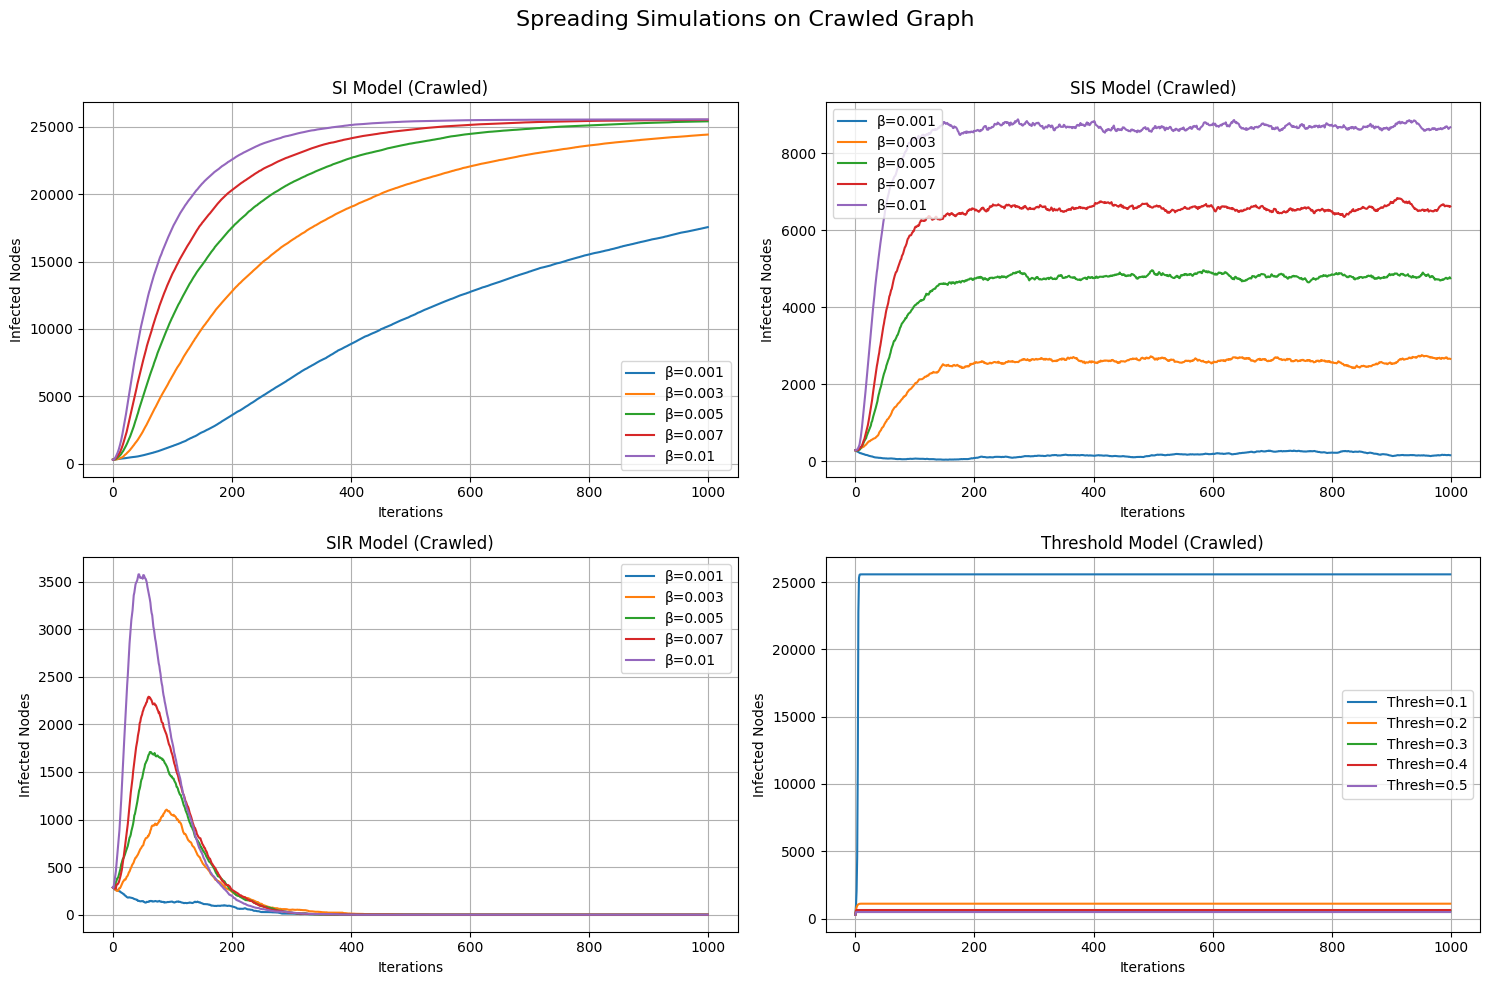

Simulating on Erdos-Renyi graph with adjusted settings...


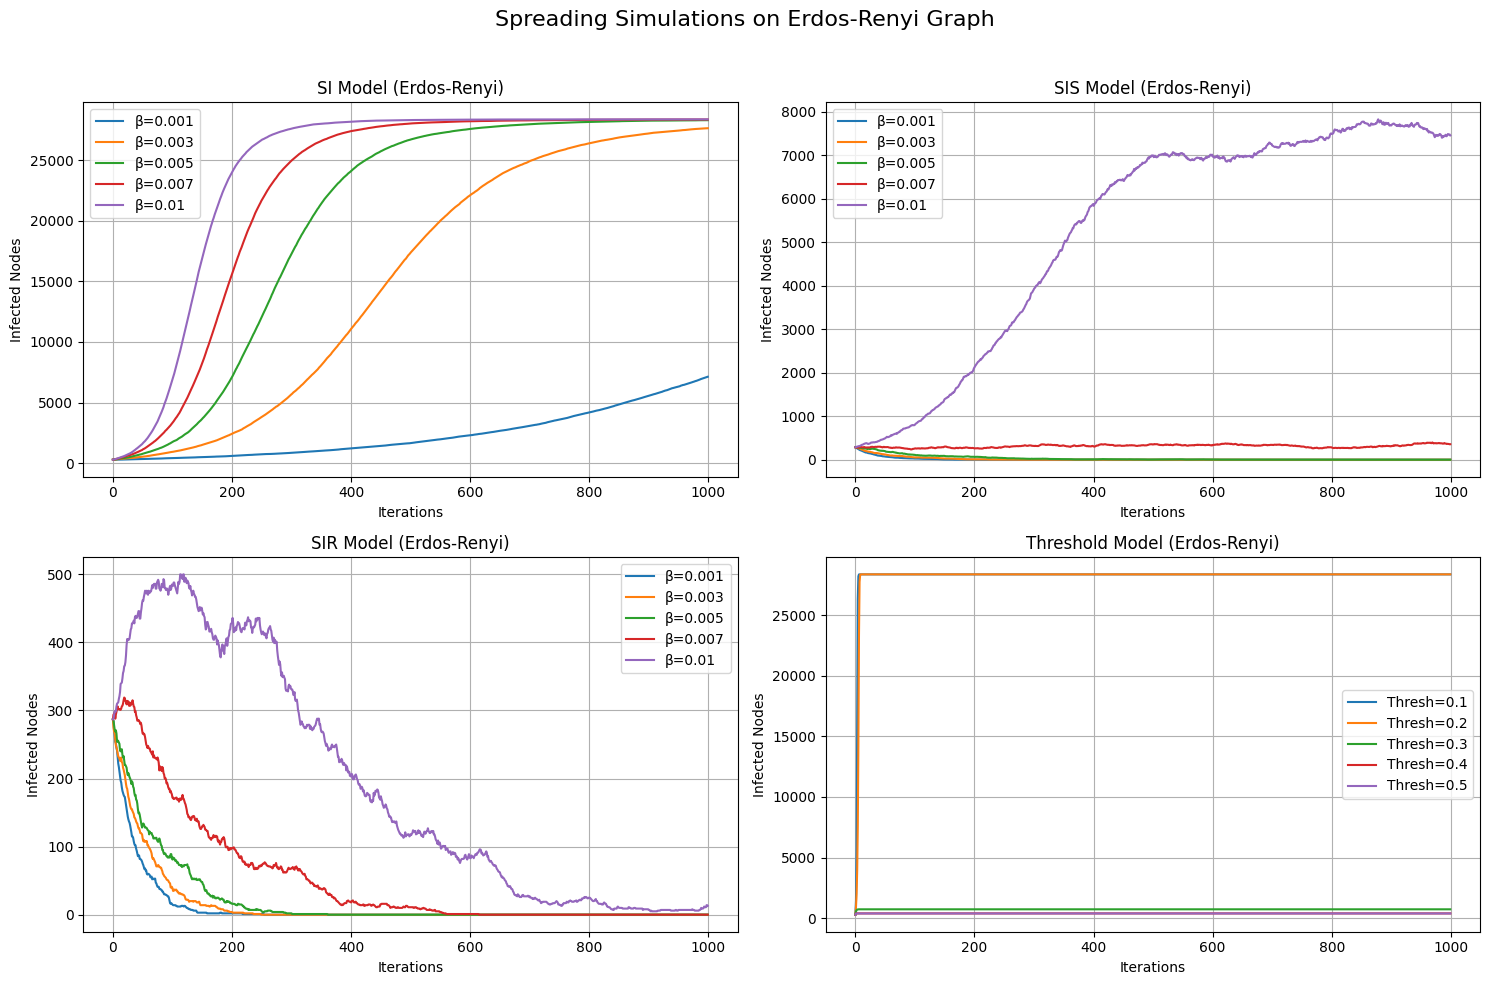

Simulating on Barabasi-Albert graph with adjusted settings...


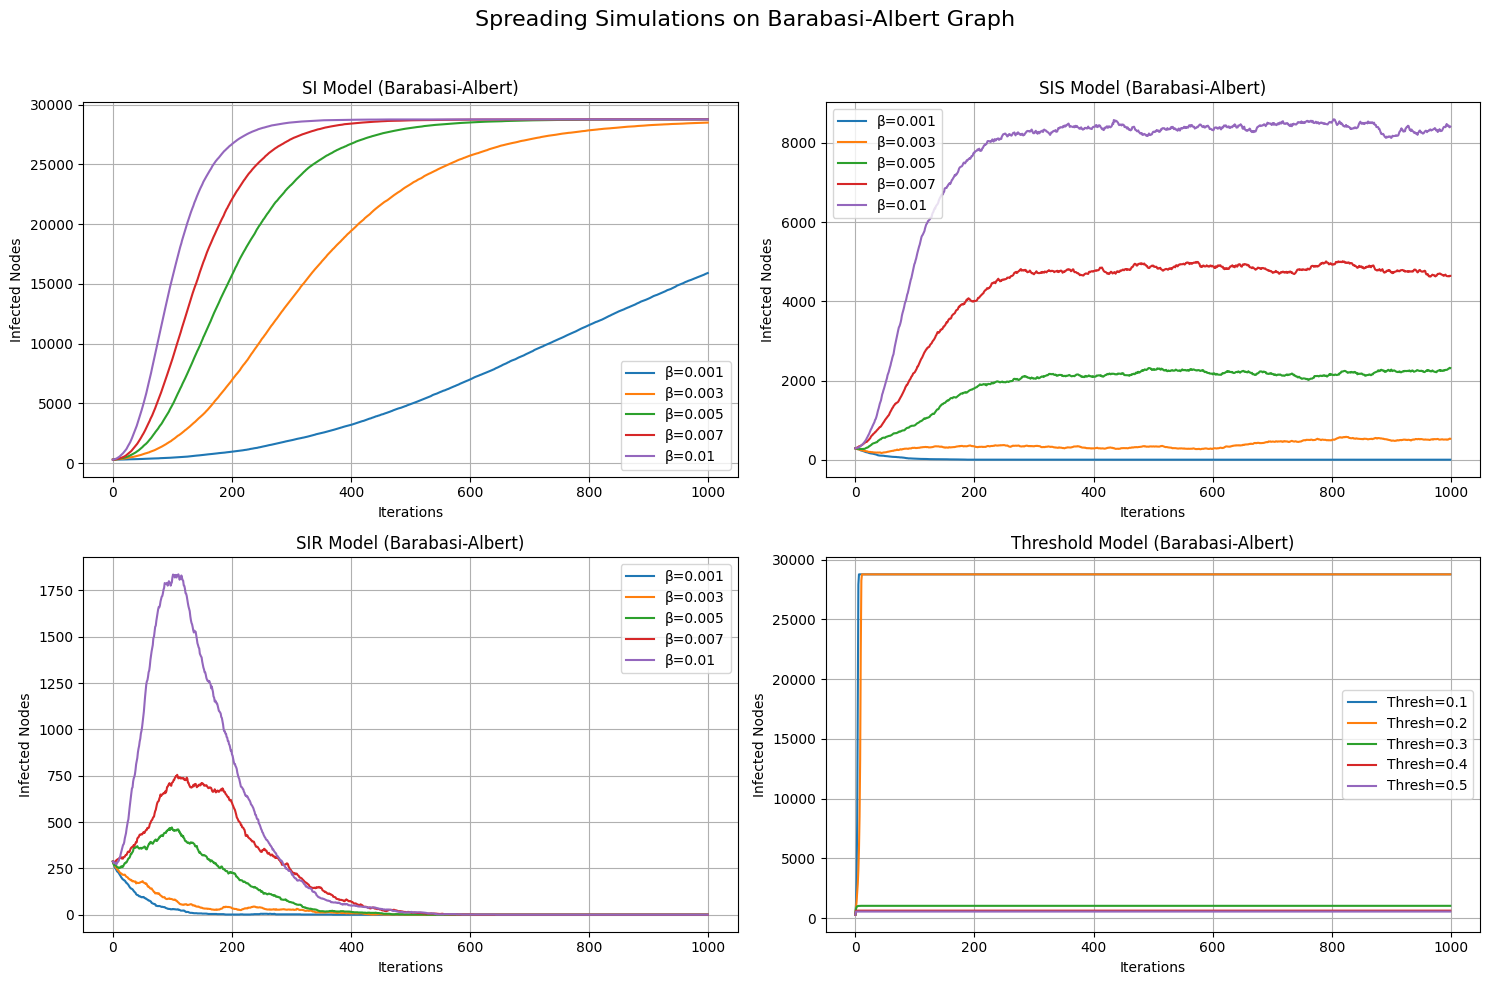


Total execution time: 83.27 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Generate comparable synthetic graphs
num_nodes = crawled_graph.number_of_nodes()
num_edges = crawled_graph.number_of_edges()
er_graph = nx.gnm_random_graph(num_nodes, num_edges)
ba_graph = nx.barabasi_albert_graph(num_nodes, m=max(1, num_edges // num_nodes))

graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Adjusted Parameters
beta_values = [0.001, 0.003, 0.005, 0.007, 0.01]  # Lower β values for slower spread
gamma_values = [0.01, 0.03, 0.05, 0.07, 0.1]
threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Fixed number of iterations
ITERATIONS = 1000

def select_initial_infected(graph, proportion=0.01):  # Reduced from 5% to 1%
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] for iteration in iterations_data]
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    for label, counts in results.items():
        ax.plot(counts, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Infected Nodes')
    ax.legend()
    ax.grid()

# Measure total execution time
total_start_time = time.time()

for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph with adjusted settings...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in threshold_values:
                infected_counts = simulate_model(graph, model_name, threshold=threshold)
                label = f"Thresh={threshold}"
                results[label] = infected_counts
        else:
            for beta in beta_values:
                gamma = gamma_values[1] if model_name in ['SIS', 'SIR'] else None
                infected_counts = simulate_model(graph, model_name, beta=beta, gamma=gamma)
                label = f"β={beta}"
                results[label] = infected_counts

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Measure total runtime and print in minutes
total_end_time = time.time()
total_time_minutes = (total_end_time - total_start_time) / 60
print(f"\nTotal execution time: {total_time_minutes:.2f} minutes")


# Fixed number of nodes

Loading and Removing Duplicates:

df_unweighted = df[['author1', 'author2']].drop_duplicates() ensures no duplicate edges are present in the DataFrame before creating the graph.
Creating the Undirected Graph:

The graph is created using nx.from_pandas_edgelist(df_unweighted, 'author1', 'author2'), which ensures it is undirected, and only unique edges are included.
Validation of Node Count:

The script checks the number of nodes in the graph and prints whether it matches the expected value (19549).


Numero di nodi nel grafo: 19549
Il numero di nodi è corretto! Il problema deve essere altrove
Simulating on Crawled graph...


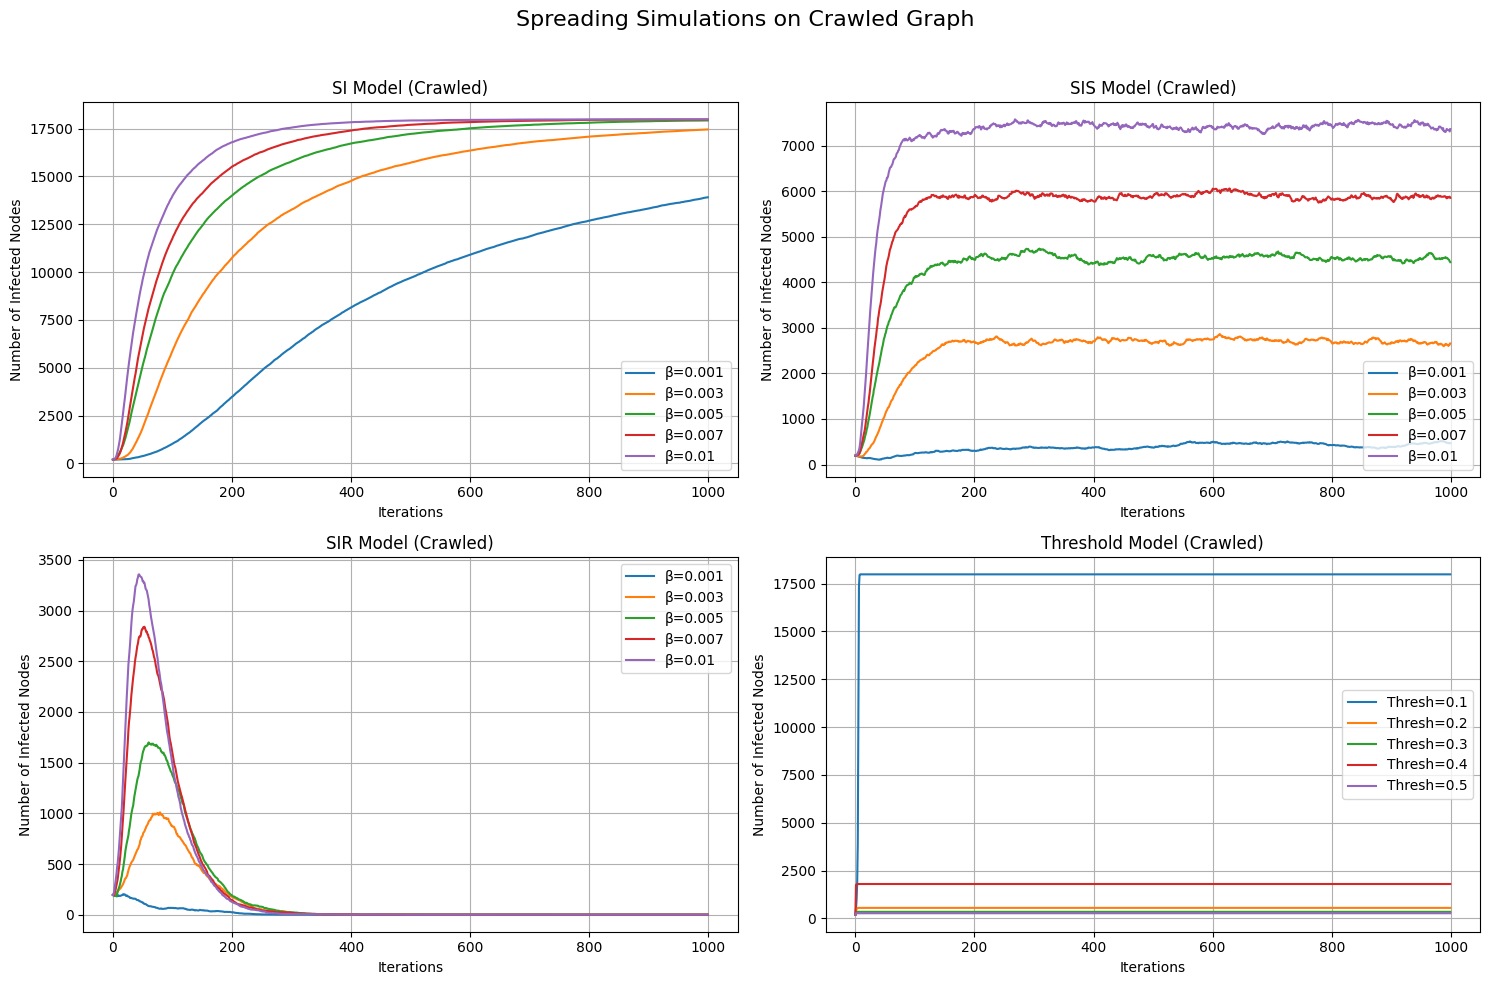

Simulating on Erdos-Renyi graph...


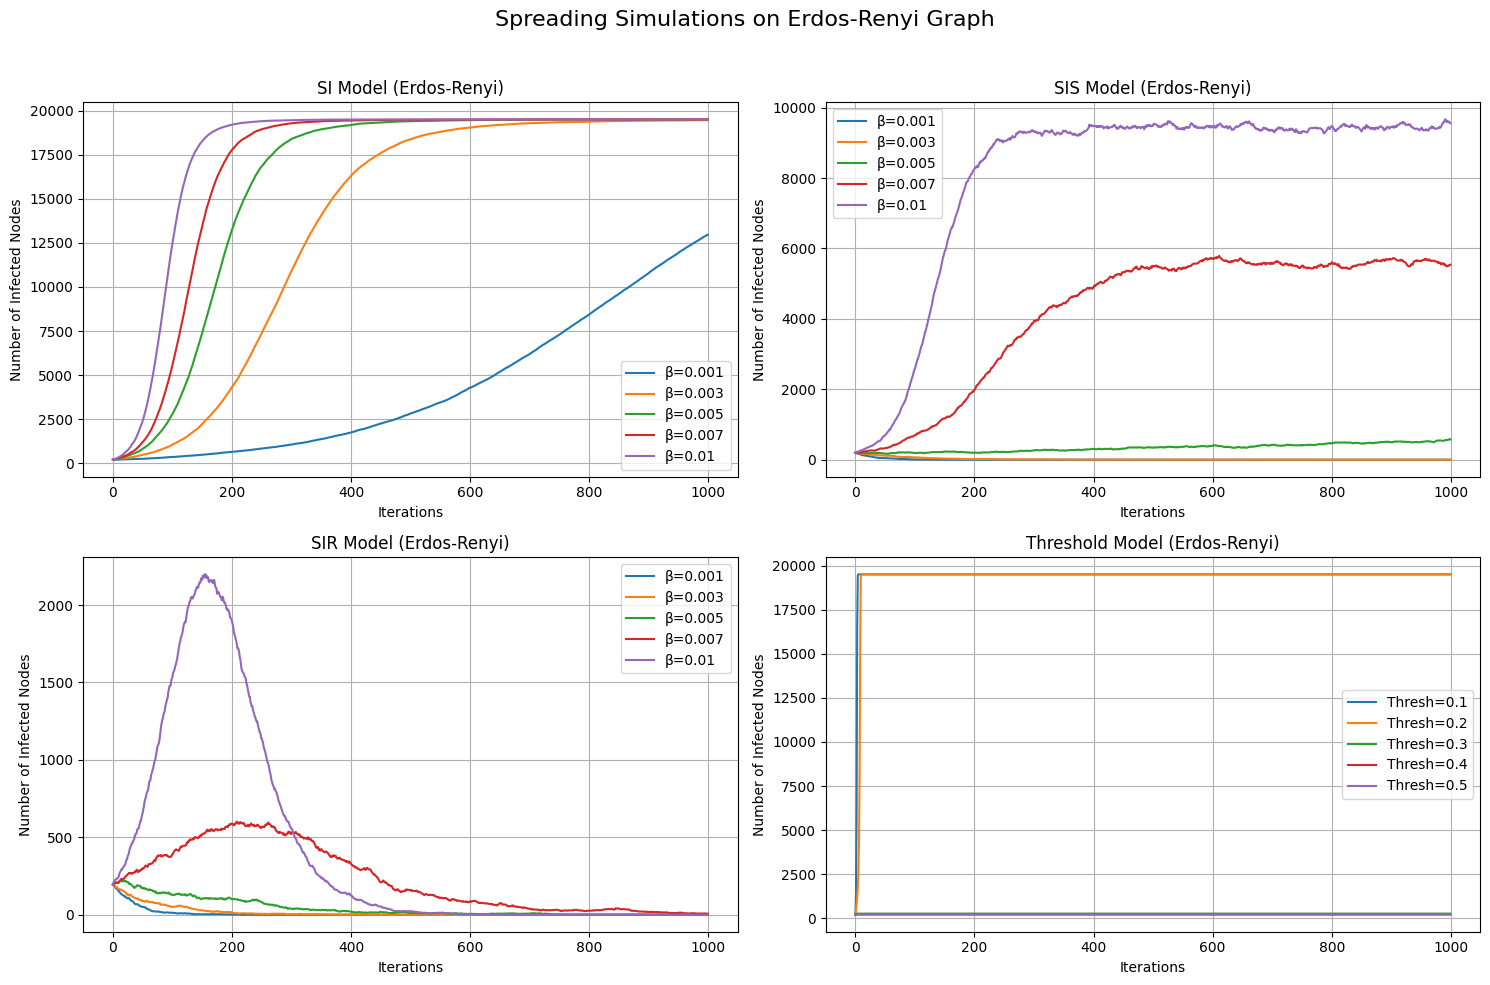

Simulating on Barabasi-Albert graph...


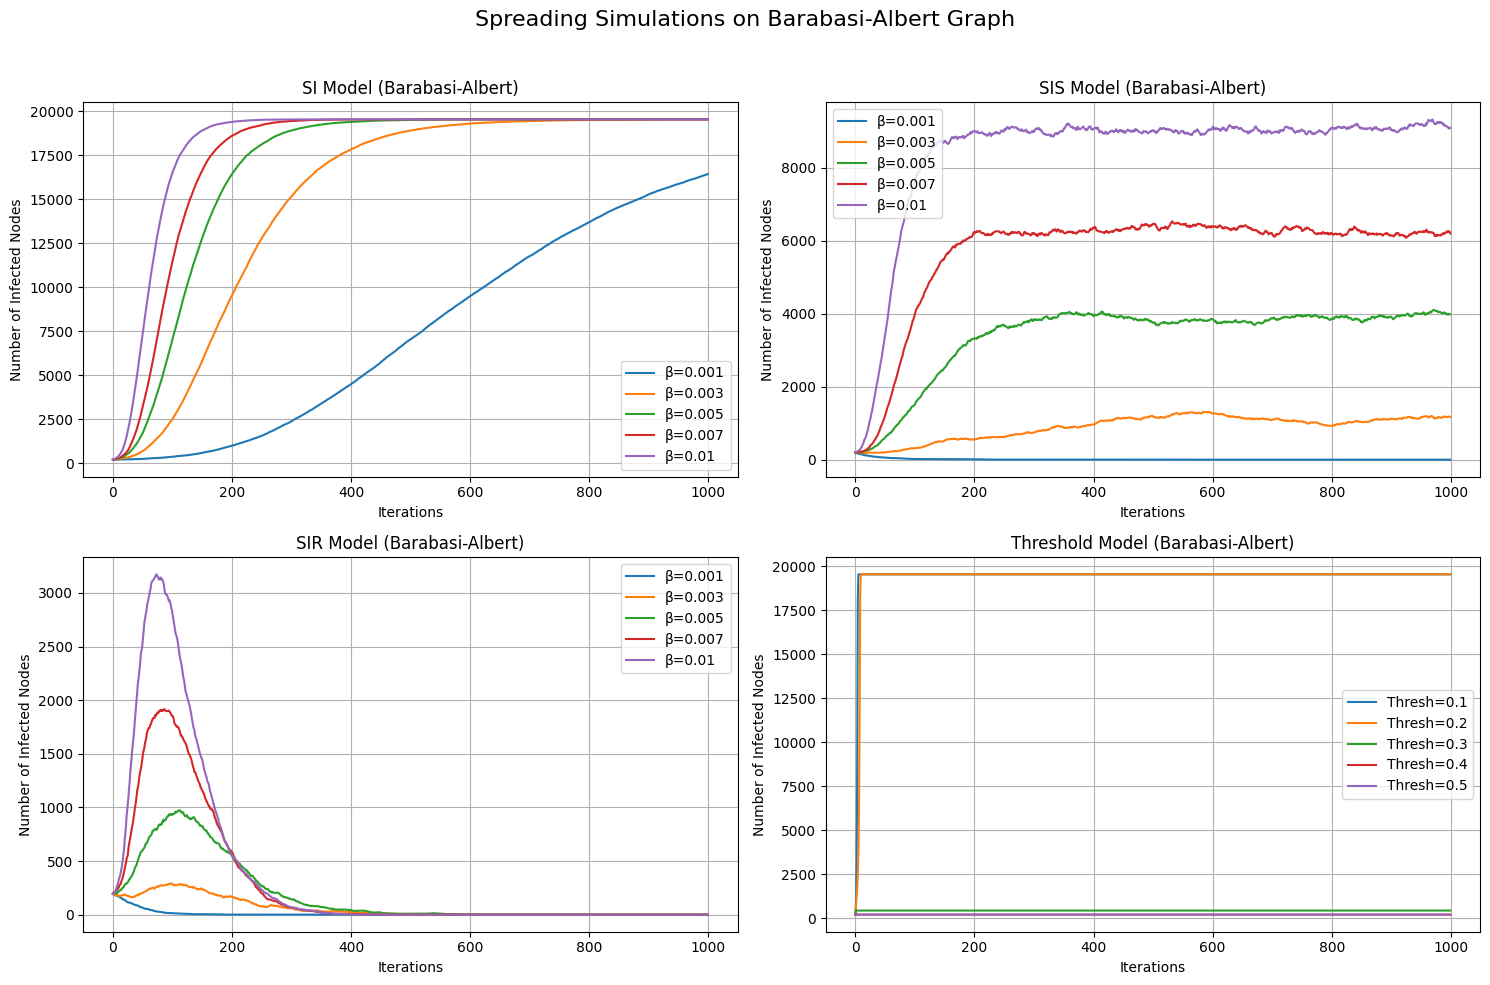


Total execution time: 51.41 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
df = pd.read_csv(edgelist_path)

# Remove duplicate edges and create the undirected graph
df_unweighted = df[['author1', 'author2']].drop_duplicates()
crawled_graph = nx.from_pandas_edgelist(df_unweighted, 'author1', 'author2')

# Verifica il numero di nodi
num_nodes = crawled_graph.number_of_nodes()
print(f"\nNumero di nodi nel grafo: {num_nodes}")

# Ensure exactly 19549 nodes in the crawled graph
if num_nodes == 19549:
    print("Il numero di nodi è corretto! Il problema deve essere altrove")
else:
    print(f"Il numero di nodi è errato! N = {num_nodes}")

# Define graph parameters
NUM_NODES = 19549
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA_VALUES = [0.001, 0.003, 0.005, 0.007, 0.01]  # Infection rate
GAMMA_VALUES = [0.01, 0.03, 0.05, 0.07, 0.1]  # Recovery rate
THRESHOLD_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5]  # Activation threshold
ITERATIONS = 1000  # Fixed number of iterations

def select_initial_infected(graph, proportion=0.01):
    """Select initial infected nodes based on a percentage of the graph size."""
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    """Simulates the given epidemic model on the network and returns infection dynamics."""
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] for iteration in iterations_data]  # Raw number of infected nodes
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    """Plots infection spread over time with raw number of infected nodes."""
    for label, infected_counts in results.items():
        ax.plot(infected_counts, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Number of Infected Nodes')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in THRESHOLD_VALUES:
                results[f"Thresh={threshold}"] = simulate_model(graph, model_name, threshold=threshold)
        else:
            for beta in BETA_VALUES:
                gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                results[f"β={beta}"] = simulate_model(graph, model_name, beta=beta, gamma=gamma)

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")



In [ ]:
print(len(max(nx.connected_components(crawled_graph), key=len)))  # Size of the largest connected component


17960


In [ ]:
print(nx.is_connected(crawled_graph))

False


In [ ]:
print(len(max(nx.connected_components(crawled_graph), key=len)))  # Should be ≈ 18,000


17960


In [ ]:
R0 = BETA_VALUES[2] / GAMMA_VALUES[1]
print("Basic Reproduction Number (R0):", R0)

Basic Reproduction Number (R0): 0.16666666666666669


In [ ]:
import pandas as pd
import networkx as nx

# Load the edgelist CSV
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
df = pd.read_csv(edgelist_path, delimiter=",", header=None, names=["Source", "Target"])

# Create the network
G = nx.from_pandas_edgelist(df, "Source", "Target")

# Basic properties
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")


Total Nodes: 19551
Total Edges: 62085


directed graph


Numero di nodi nel grafo: 19549
Il numero di nodi è corretto! Il problema deve essere altrove
Simulating on Crawled graph...


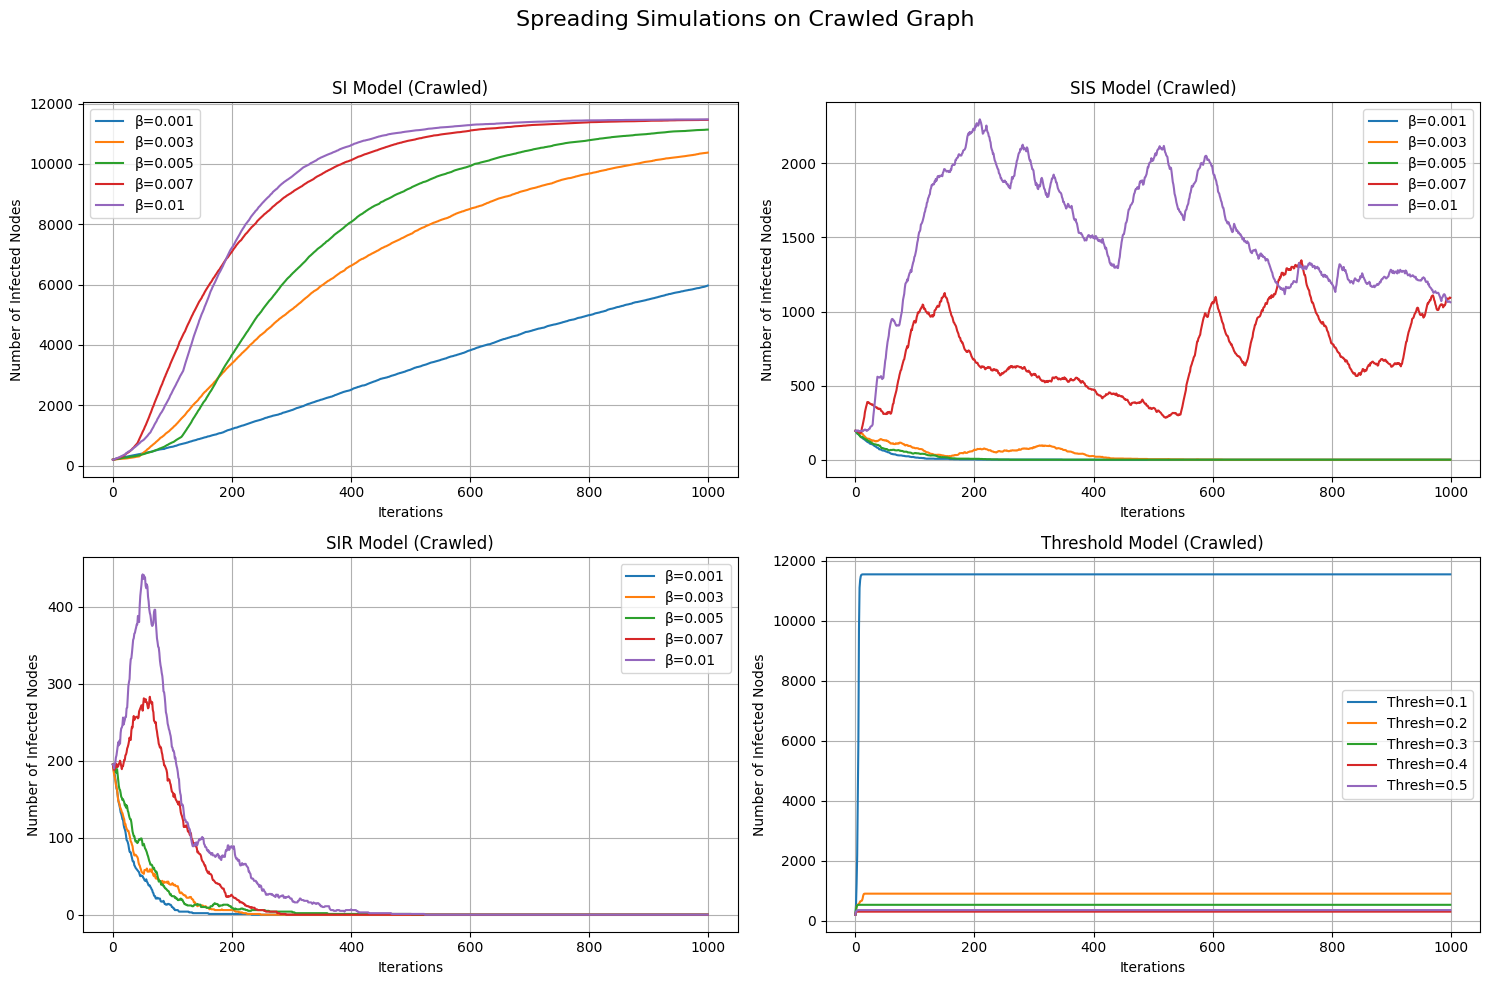

Simulating on Erdos-Renyi graph...


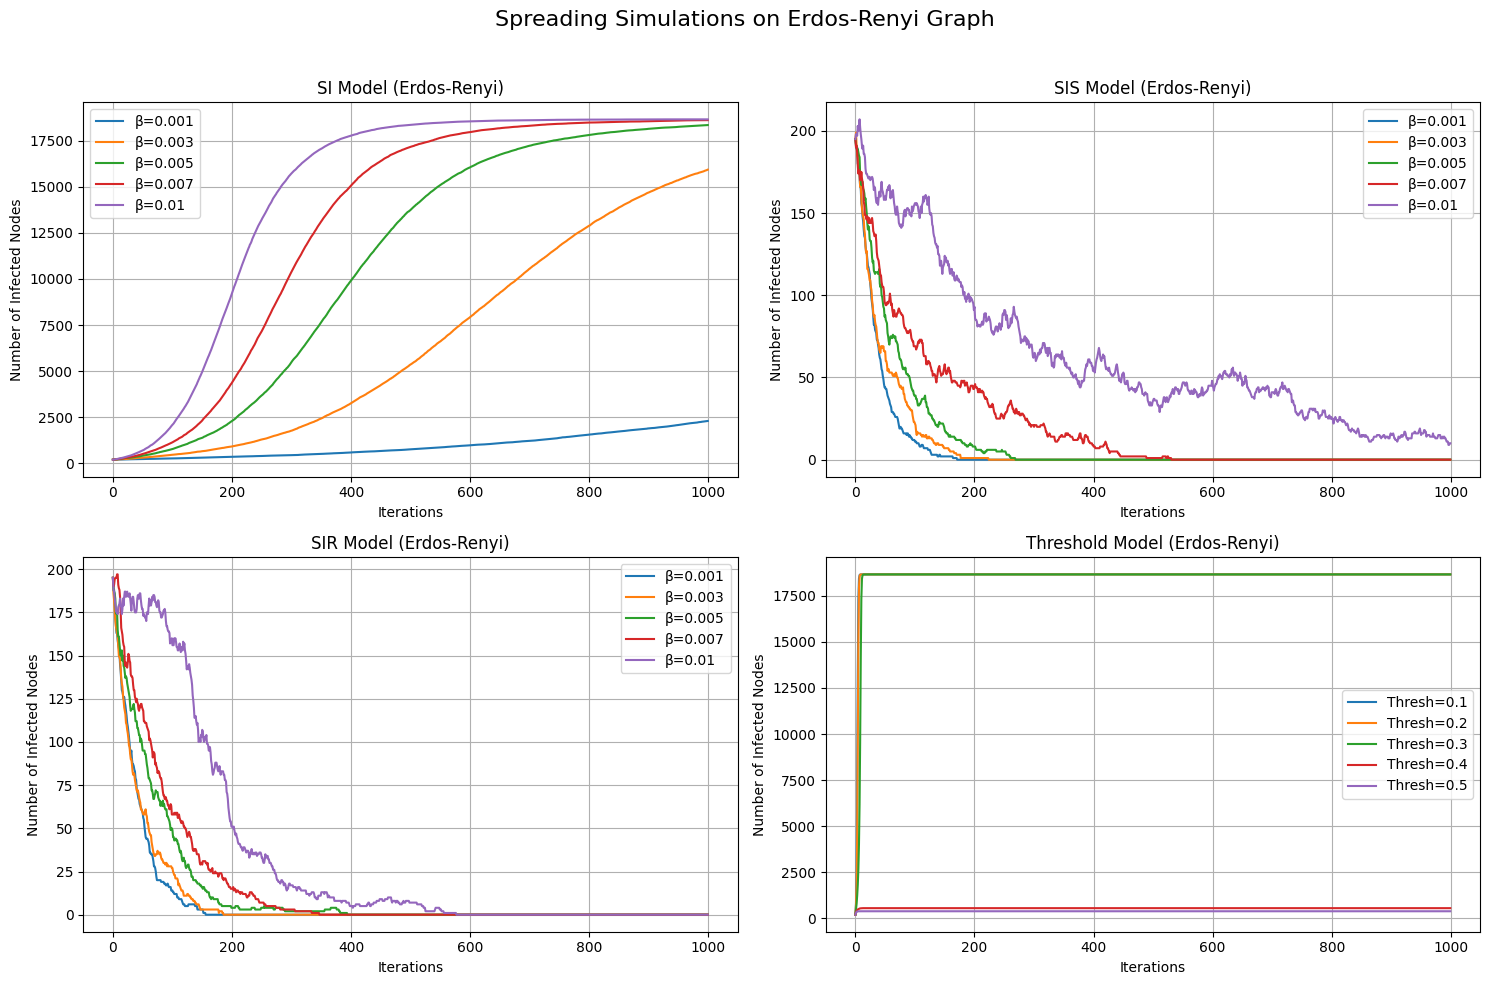

Simulating on Barabasi-Albert graph...


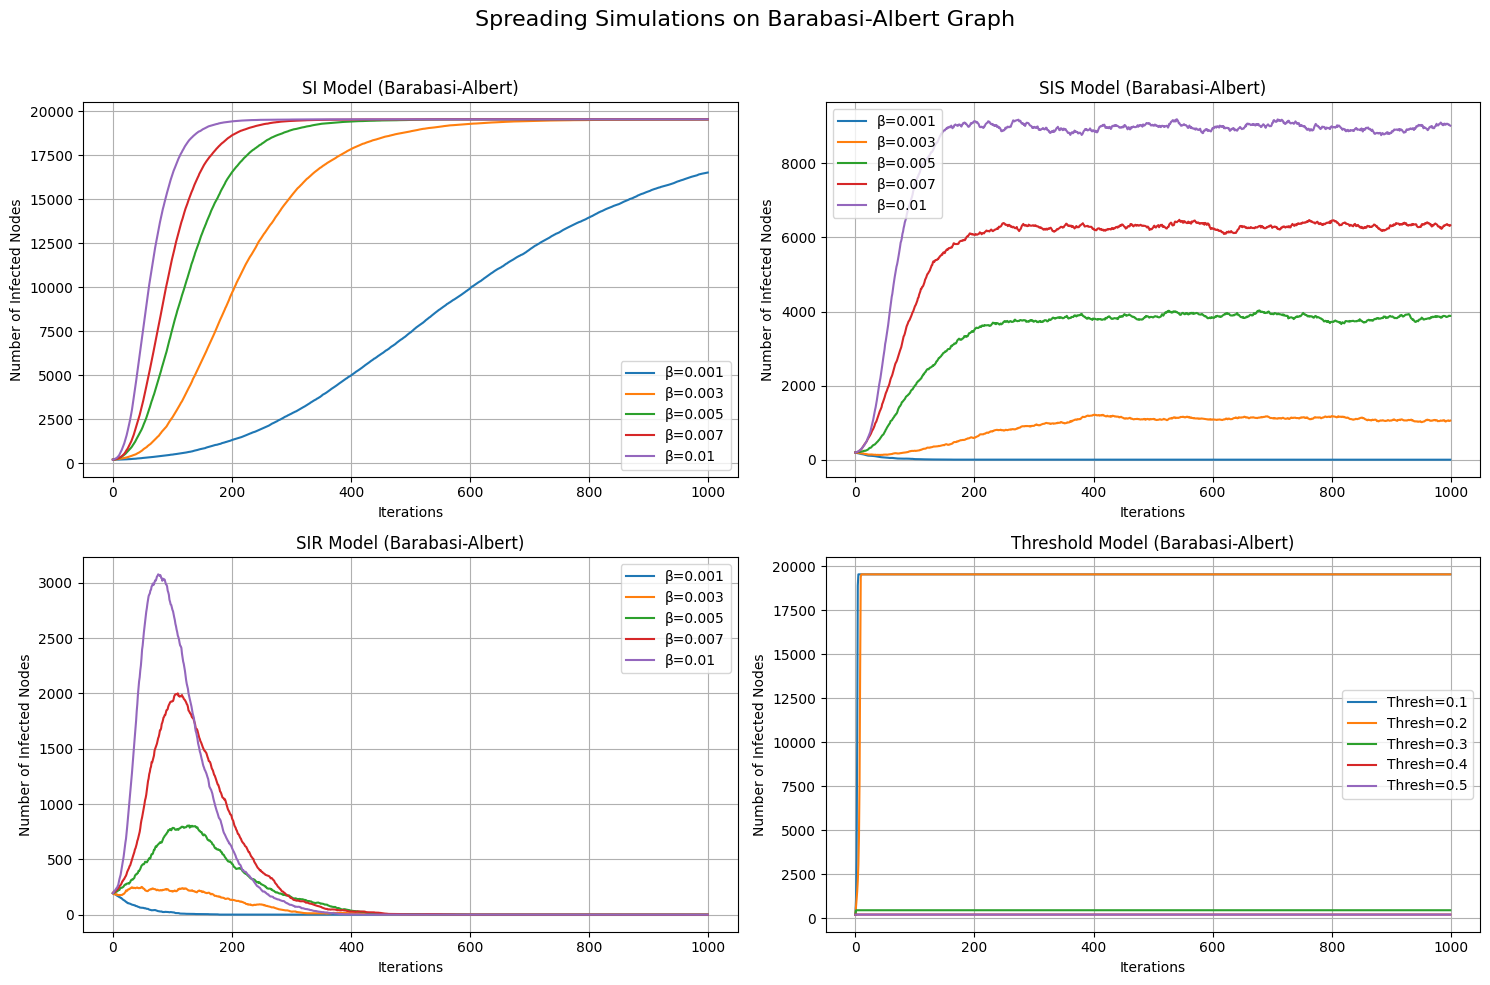


Total execution time: 64.16 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
df = pd.read_csv(edgelist_path)

# Remove duplicate edges and create the directed graph
df_unweighted = df[['author1', 'author2']].drop_duplicates()
crawled_graph = nx.from_pandas_edgelist(df_unweighted, 'author1', 'author2', create_using=nx.DiGraph())

# Verifica il numero di nodi
num_nodes = crawled_graph.number_of_nodes()
print(f"\nNumero di nodi nel grafo: {num_nodes}")

# Ensure exactly 19549 nodes in the crawled graph
if num_nodes == 19549:
    print("Il numero di nodi è corretto! Il problema deve essere altrove")
else:
    print(f"Il numero di nodi è errato! N = {num_nodes}")

# Define graph parameters
NUM_NODES = 19549
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs (directed)
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES, directed=True)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))
ba_graph = nx.DiGraph(ba_graph)  # Convert to directed graph

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA_VALUES = [0.001, 0.003, 0.005, 0.007, 0.01]  # Infection rate
GAMMA_VALUES = [0.01, 0.03, 0.05, 0.07, 0.1]  # Recovery rate
THRESHOLD_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5]  # Activation threshold
ITERATIONS = 1000  # Fixed number of iterations

def select_initial_infected(graph, proportion=0.01):
    """Select initial infected nodes based on a percentage of the graph size."""
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    """Simulates the given epidemic model on the network and returns infection dynamics."""
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] for iteration in iterations_data]  # Raw number of infected nodes
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    """Plots infection spread over time with raw number of infected nodes."""
    for label, infected_counts in results.items():
        ax.plot(infected_counts, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Number of Infected Nodes')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in THRESHOLD_VALUES:
                results[f"Thresh={threshold}"] = simulate_model(graph, model_name, threshold=threshold)
        else:
            for beta in BETA_VALUES:
                gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                results[f"β={beta}"] = simulate_model(graph, model_name, beta=beta, gamma=gamma)

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")


In [ ]:
# Inside the simulation loop for each graph
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")

    for idx, model_name in enumerate(models):
        results = {}
        max_infected_for_model = 0  # To store the max number of infected nodes for this model

        if model_name == 'Threshold':
            for threshold in THRESHOLD_VALUES:
                infected_counts = simulate_model(graph, model_name, threshold=threshold)
                results[f"Thresh={threshold}"] = infected_counts
                max_infected_for_model = max(max_infected_for_model, max(infected_counts))
        else:
            for beta in BETA_VALUES:
                gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                infected_counts = simulate_model(graph, model_name, beta=beta, gamma=gamma)
                results[f"β={beta}"] = infected_counts
                max_infected_for_model = max(max_infected_for_model, max(infected_counts))

        # Print the max number of infected nodes for this model and graph
        print(f"Max number of infected nodes for {model_name} model on {graph_name} graph: {max_infected_for_model}")


Simulating on Crawled graph...
Max number of infected nodes for SI model on Crawled graph: 11446
Max number of infected nodes for SIS model on Crawled graph: 2218
Max number of infected nodes for SIR model on Crawled graph: 890
Max number of infected nodes for Threshold model on Crawled graph: 11433
Simulating on Erdos-Renyi graph...
Max number of infected nodes for SI model on Erdos-Renyi graph: 18657
Max number of infected nodes for SIS model on Erdos-Renyi graph: 218
Max number of infected nodes for SIR model on Erdos-Renyi graph: 232
Max number of infected nodes for Threshold model on Erdos-Renyi graph: 18665
Simulating on Barabasi-Albert graph...
Max number of infected nodes for SI model on Barabasi-Albert graph: 19549
Max number of infected nodes for SIS model on Barabasi-Albert graph: 9220
Max number of infected nodes for SIR model on Barabasi-Albert graph: 3263
Max number of infected nodes for Threshold model on Barabasi-Albert graph: 19549


Undirected and percent plots

Simulating on Crawled graph...


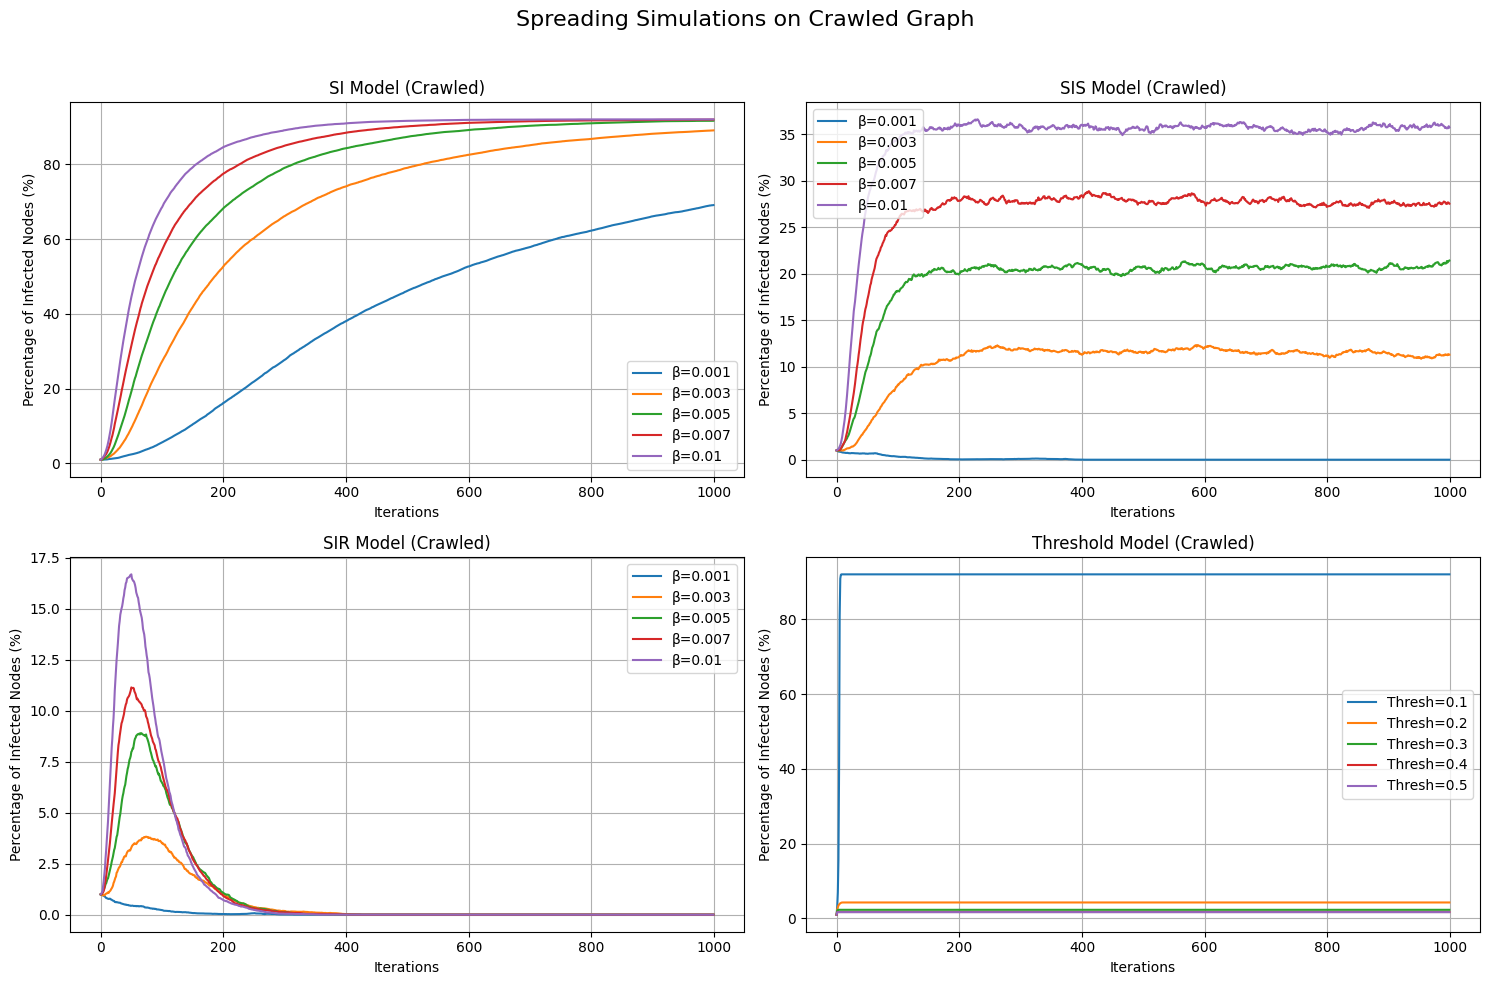

Simulating on Erdos-Renyi graph...


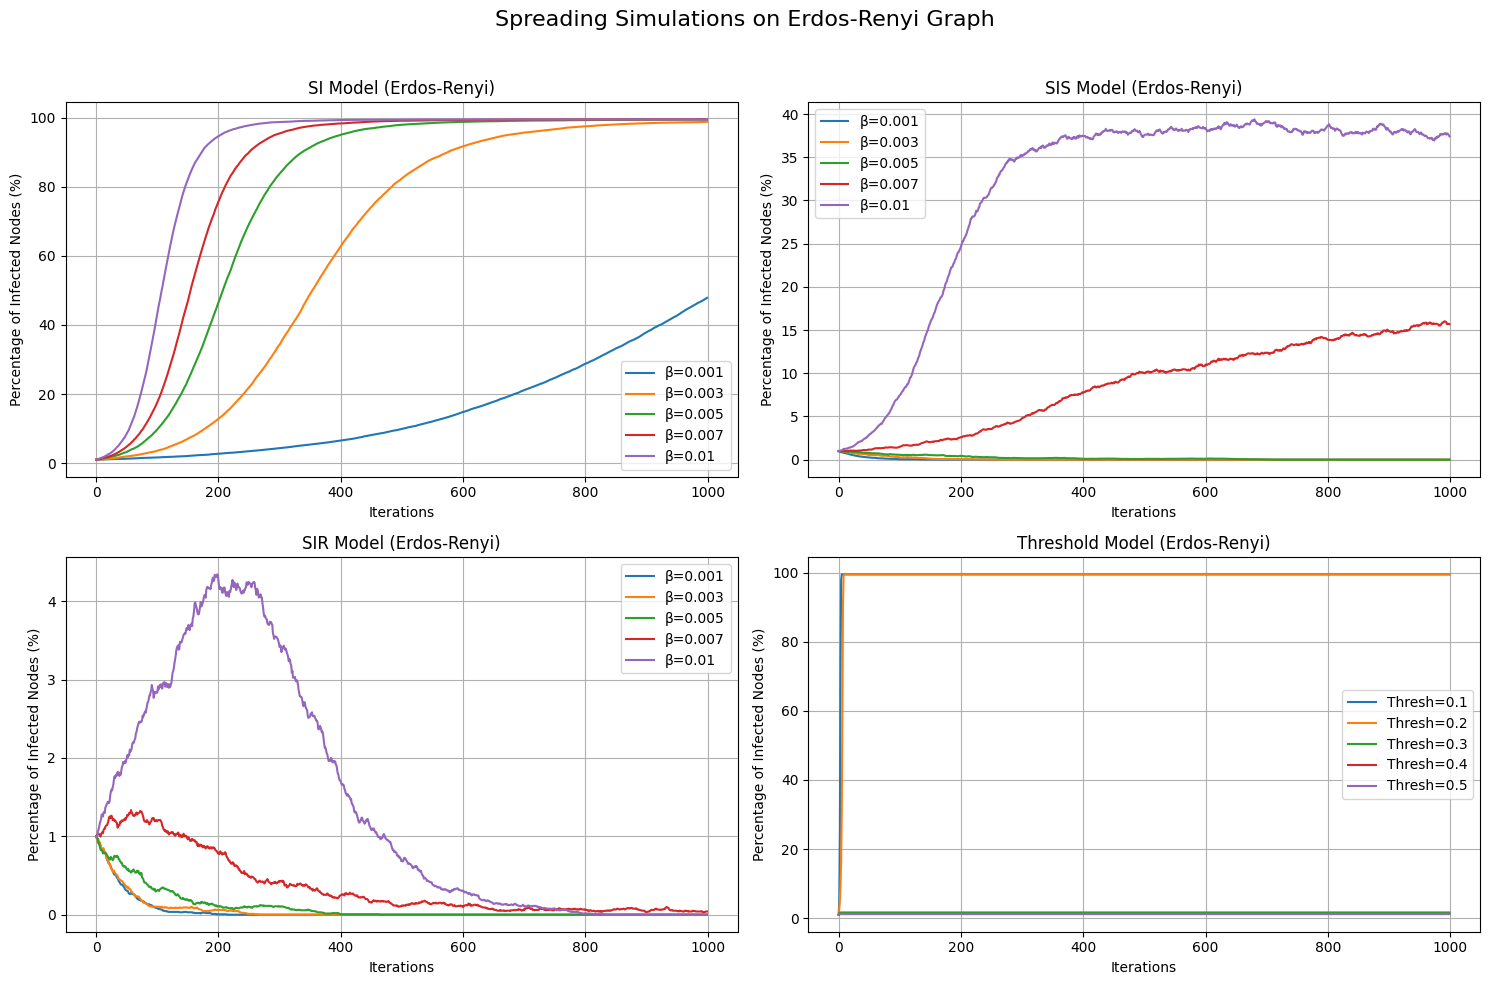

Simulating on Barabasi-Albert graph...


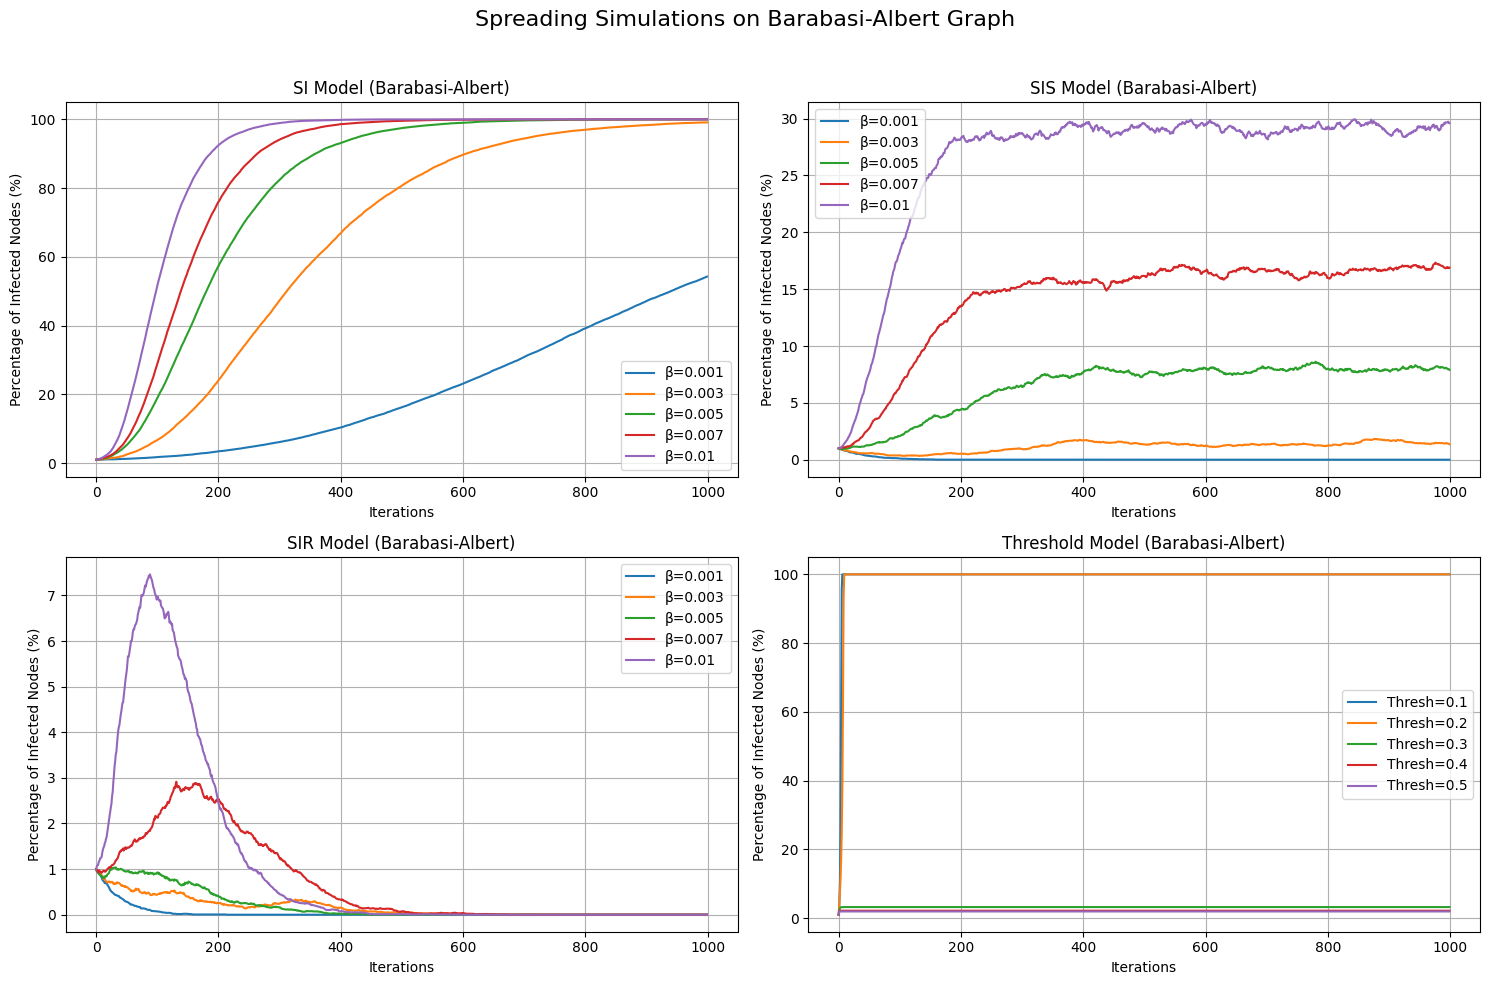


Total execution time: 50.85 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes in the crawled graph
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Define graph parameters
NUM_NODES = 19549
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA_VALUES = [0.001, 0.003, 0.005, 0.007, 0.01]  # Infection rate
GAMMA_VALUES = [0.01, 0.03, 0.05, 0.07, 0.1]  # Recovery rate
THRESHOLD_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5]  # Activation threshold
ITERATIONS = 1000  # Fixed number of iterations

def select_initial_infected(graph, proportion=0.01):
    """Select initial infected nodes based on a percentage of the graph size."""
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    """Simulates the given epidemic model on the network and returns infection dynamics."""
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]  # Convert to %
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    """Plots infection spread over time with percentage scale."""
    for label, percentages in results.items():
        ax.plot(percentages, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Percentage of Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in THRESHOLD_VALUES:
                results[f"Thresh={threshold}"] = simulate_model(graph, model_name, threshold=threshold)
        else:
            for beta in BETA_VALUES:
                gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                results[f"β={beta}"] = simulate_model(graph, model_name, beta=beta, gamma=gamma)

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")


# inizial seed value 1% but with differnt seed strategy

undirected

seed fixed 1% but with different strategy of spreading:random ,highdegree, closeness, betweeness

Simulating on Crawled graph with different seeding strategies...


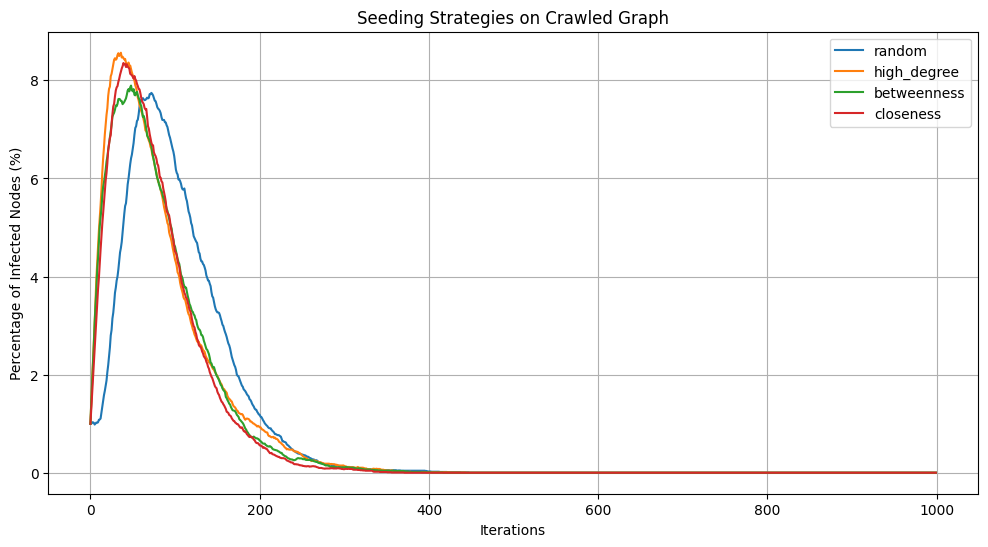

Simulating on Erdos-Renyi graph with different seeding strategies...


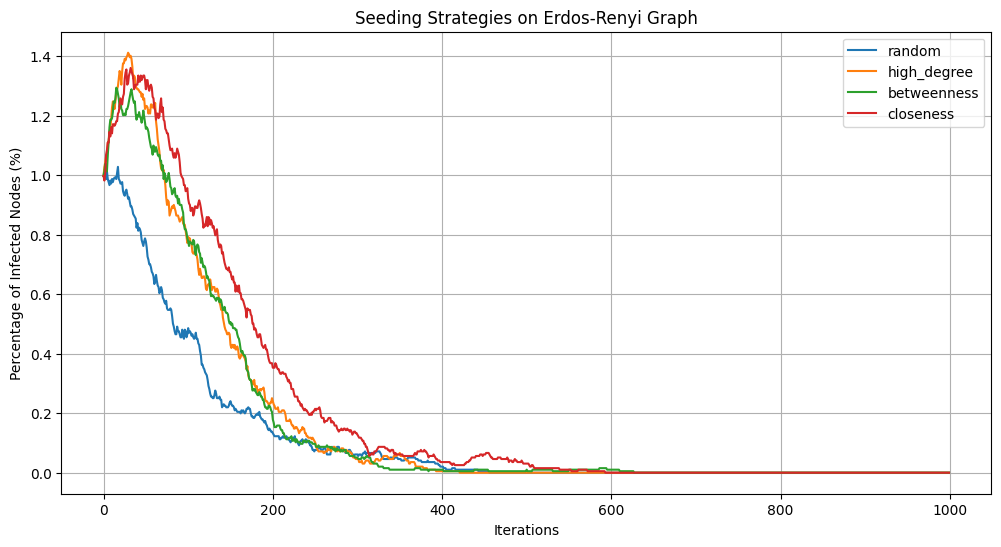

Simulating on Barabasi-Albert graph with different seeding strategies...


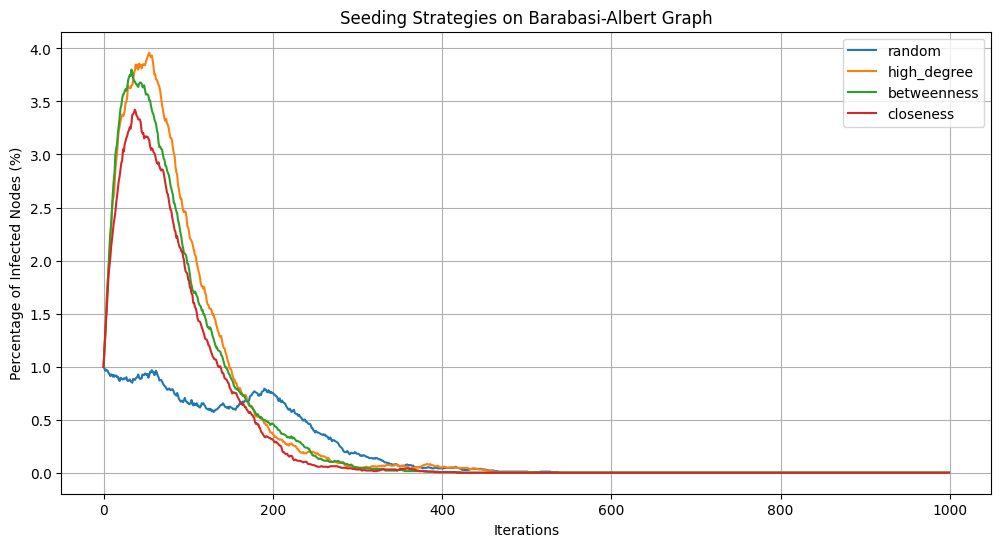


Total execution time: 236.51 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Define graph parameters
NUM_NODES = 19549
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Store graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA = 0.005   # Infection rate
GAMMA = 0.03   # Recovery rate
ITERATIONS = 1000
SEED_PROPORTION = 0.01  # 1% of nodes as initial seeds

def select_initial_infected(graph, strategy='random'):
    """Select initial infected nodes based on different strategies."""
    num_seeds = max(1, int(SEED_PROPORTION * len(graph.nodes)))
    if strategy == 'random':
        return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)
    elif strategy == 'high_degree':
        return [node for node, _ in sorted(graph.degree(), key=lambda x: x[1], reverse=True)[:num_seeds]]
    elif strategy == 'betweenness':
        betweenness = nx.betweenness_centrality(graph)
        return [node for node, _ in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:num_seeds]]
    elif strategy == 'closeness':
        closeness = nx.closeness_centrality(graph)
        return [node for node, _ in sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:num_seeds]]
    else:
        raise ValueError("Invalid seed selection strategy.")

def simulate_model(graph, model_name, seed_strategy):
    """Simulates epidemic spread using different seeding strategies."""
    model = ep.SIRModel(graph)  # Using SIR as default model
    config = mc.Configuration()
    config.add_model_parameter('beta', BETA)
    config.add_model_parameter('gamma', GAMMA)

    initial_infected = select_initial_infected(graph, strategy=seed_strategy)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(ITERATIONS)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]
    return infected_counts

def plot_simulation_results(graph_name, results, ax):
    """Plots infection spread for different seed selection strategies."""
    for strategy, percentages in results.items():
        ax.plot(percentages, label=strategy)
    ax.set_title(f"Seeding Strategies on {graph_name} Graph")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Percentage of Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations for different seeding strategies
seeding_strategies = ['random', 'high_degree', 'betweenness', 'closeness']
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph with different seeding strategies...")
    fig, ax = plt.subplots(figsize=(12, 6))

    results = {}
    for strategy in seeding_strategies:
        results[strategy] = simulate_model(graph, 'SIR', seed_strategy=strategy)

    plot_simulation_results(graph_name, results, ax)
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")


# Different inizial seed values 0.5%, 1%, 2%, 5%, 10%, but not different  strategy and and no different values for beta and gamma

undirected

Simulating on Crawled graph...
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)


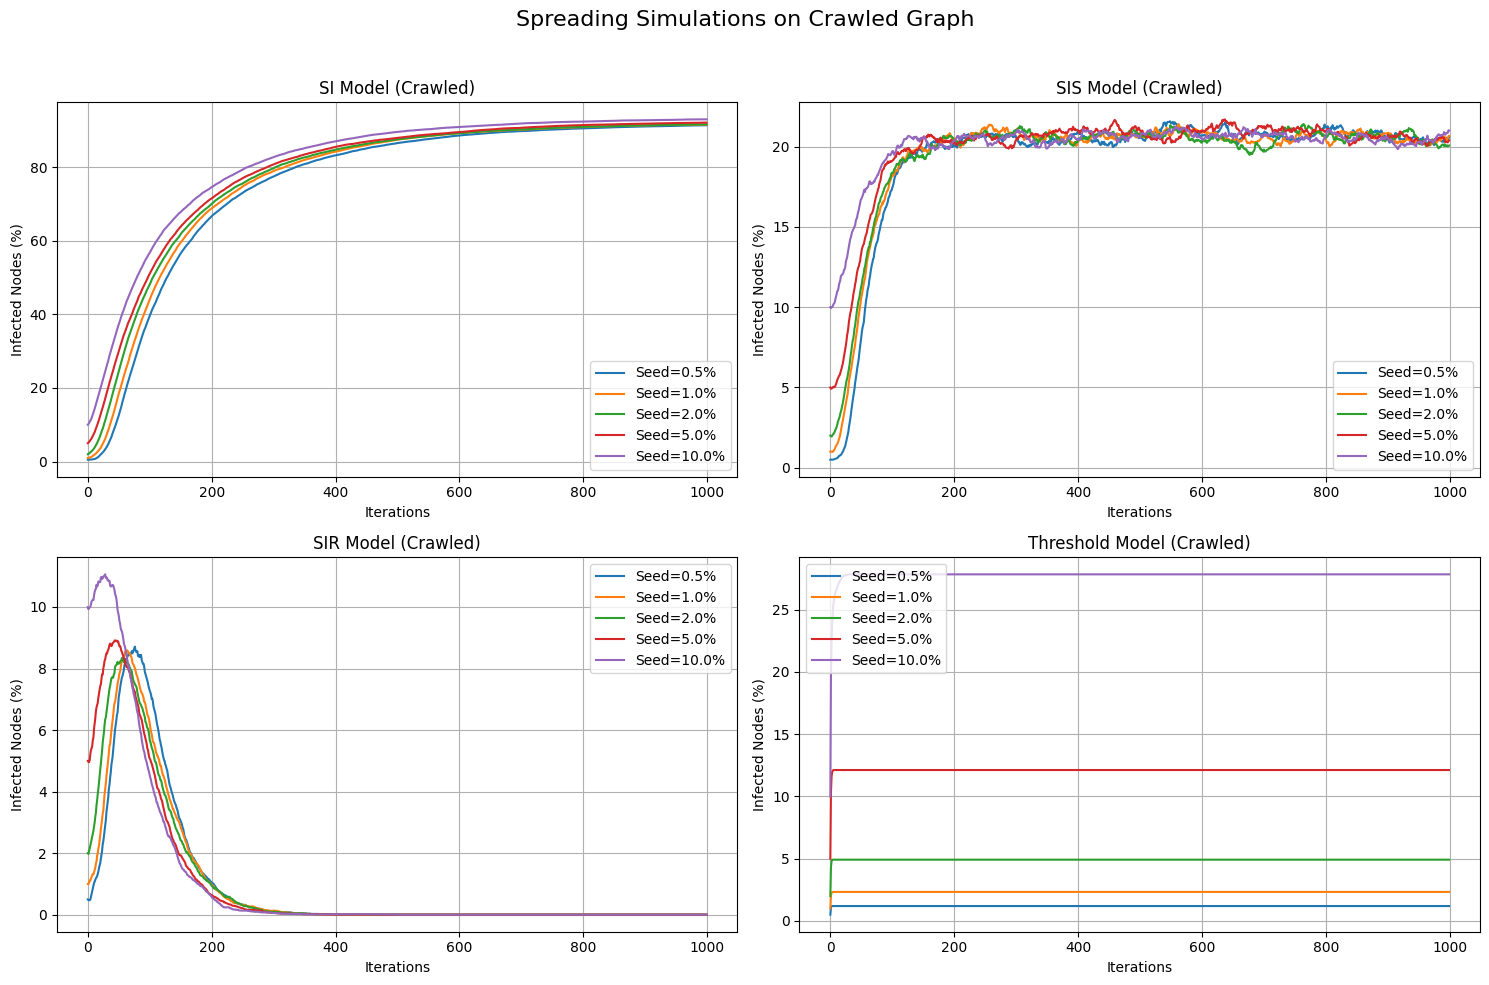

Simulating on Erdos-Renyi graph...
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)


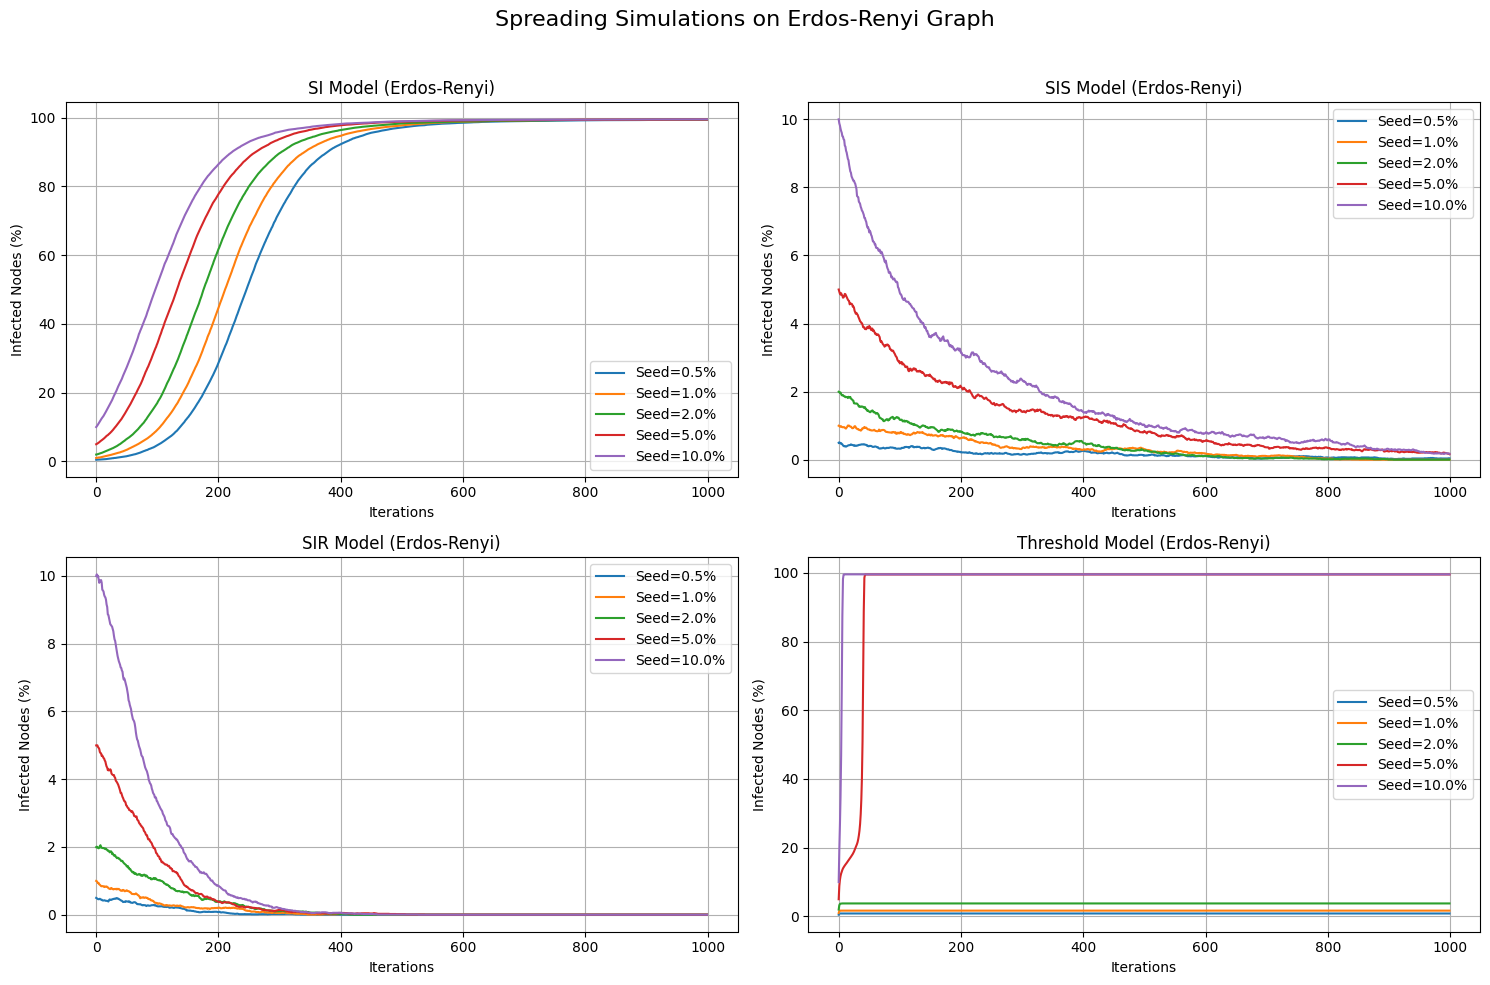

Simulating on Barabasi-Albert graph...
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)
Selecting 97 initial infected nodes (0.5%)
Selecting 195 initial infected nodes (1.0%)
Selecting 390 initial infected nodes (2.0%)
Selecting 977 initial infected nodes (5.0%)
Selecting 1954 initial infected nodes (10.0%)


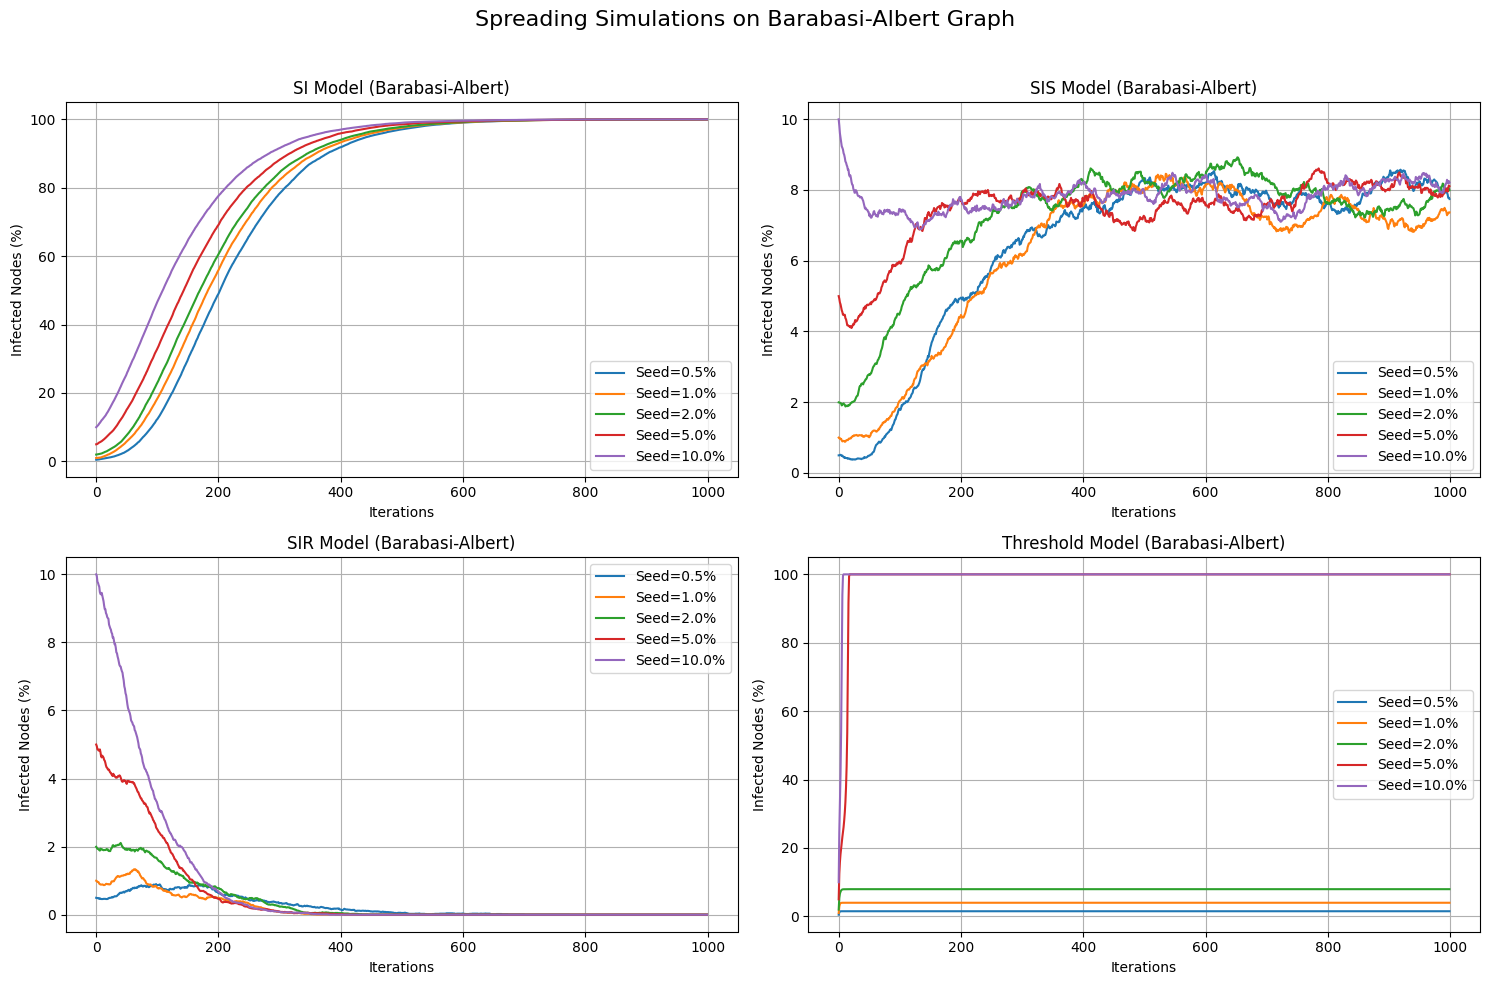


Total execution time: 52.72 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes in the crawled graph
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Define graph parameters
NUM_NODES = 19549
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA = 0.005  # Infection rate
GAMMA = 0.03  # Recovery rate
THRESHOLD = 0.3  # Activation threshold
SEED_SIZES = [0.005, 0.01, 0.02, 0.05, 0.1]  # 0.5%, 1%, 2%, 5%, 10%
ITERATIONS = 1000

def select_initial_infected(graph, proportion):
    """Select initial infected nodes based on a percentage of the graph size."""
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    print(f"Selecting {num_seeds} initial infected nodes ({proportion*100:.1f}%)")
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, seed_size):
    """Simulates the given epidemic model on the network."""
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
        config.add_model_parameter('lambda', GAMMA)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
        config.add_model_parameter('gamma', GAMMA)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        for node in graph.nodes:
            config.add_node_configuration("threshold", node, THRESHOLD)

    initial_infected = select_initial_infected(graph, seed_size)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(ITERATIONS)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]  # Convert to %
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    """Plots infection spread over time with only seed sizes in the legend."""
    for seed_size, percentages in results.items():
        ax.plot(percentages, label=f"Seed={seed_size*100:.1f}%")  # Fixed formatting
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {seed_size: simulate_model(graph, model_name, seed_size) for seed_size in SEED_SIZES}
        plot_simulation_results(graph_name, model_name, results, axes[idx // 2, idx % 2])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")




# Explicitate the  largest connected component (LCC)

Simulating on Crawled graph...


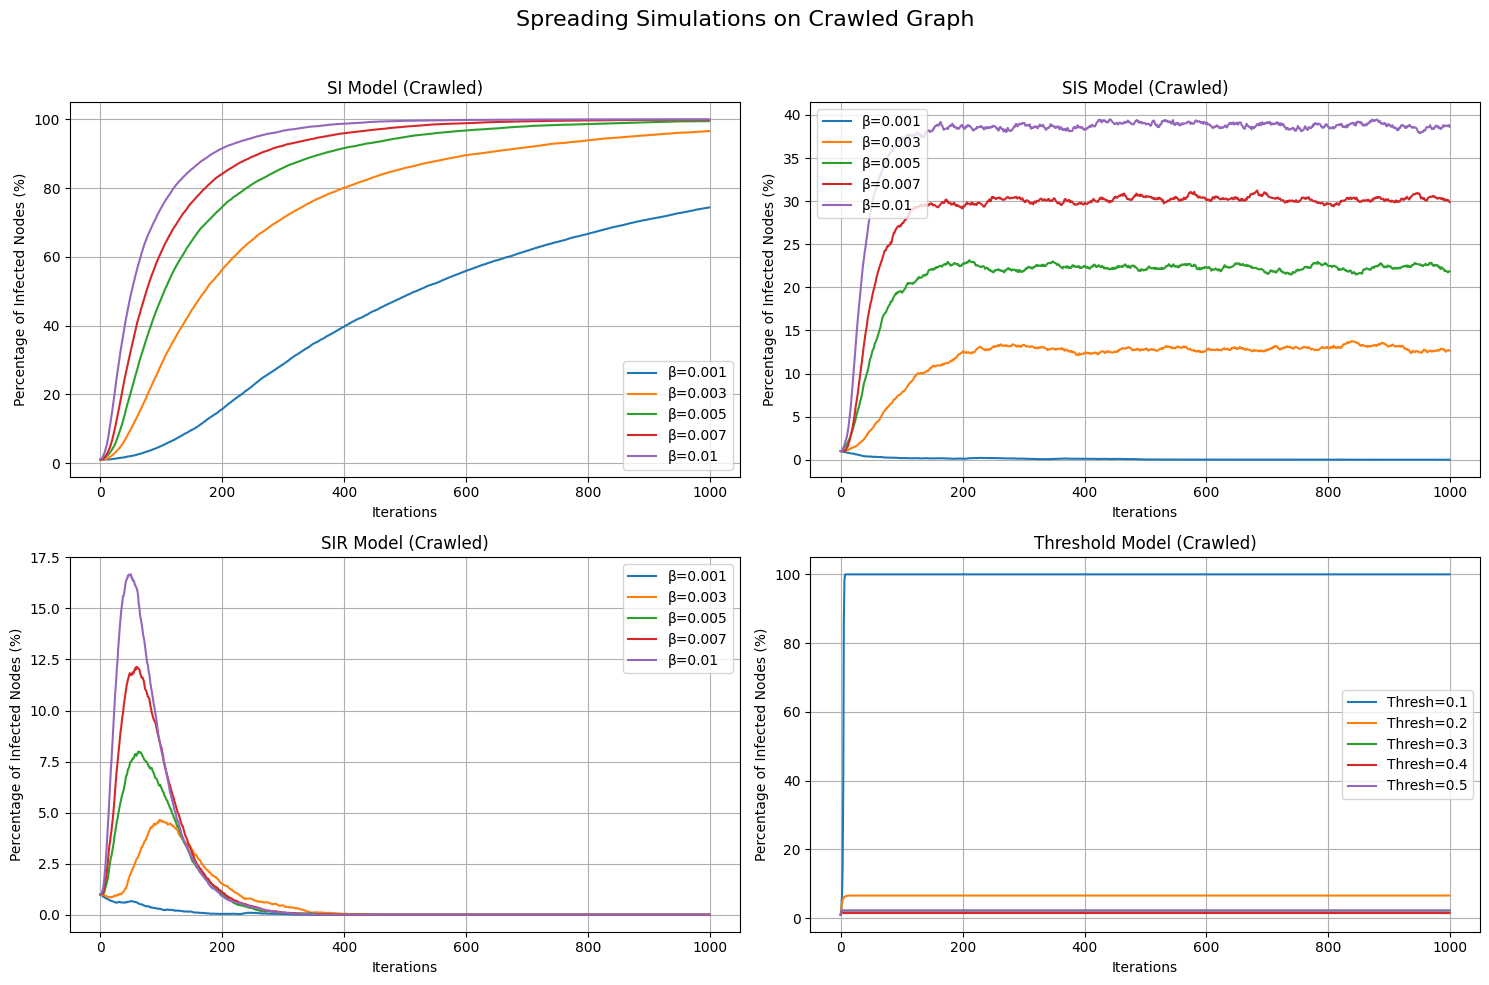

Simulating on Erdos-Renyi graph...


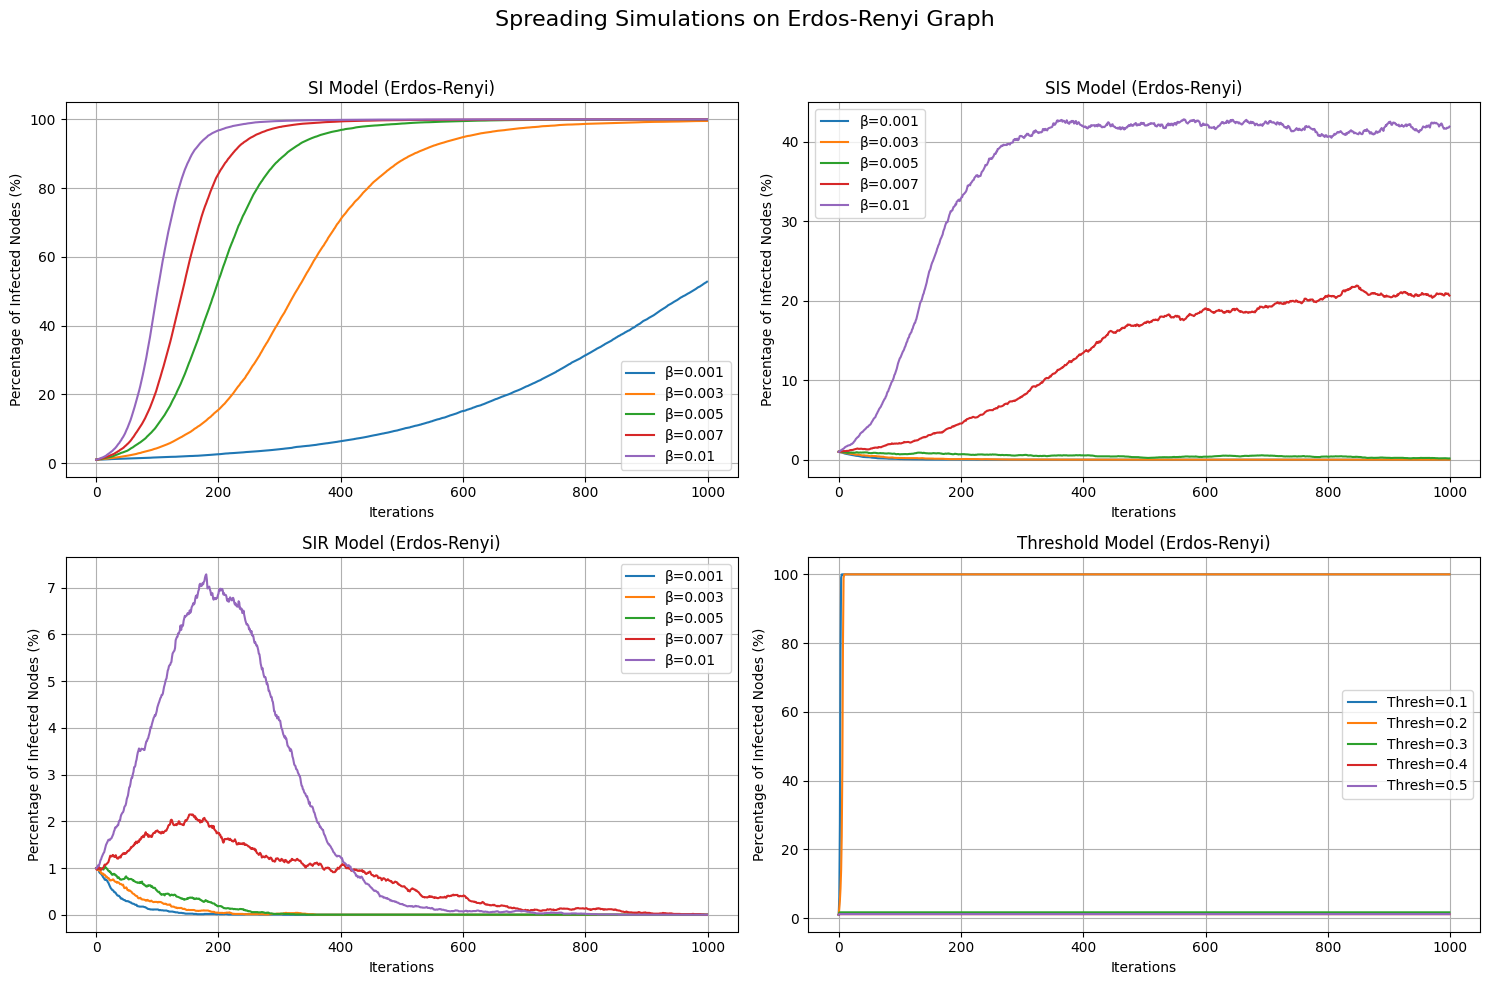

Simulating on Barabasi-Albert graph...


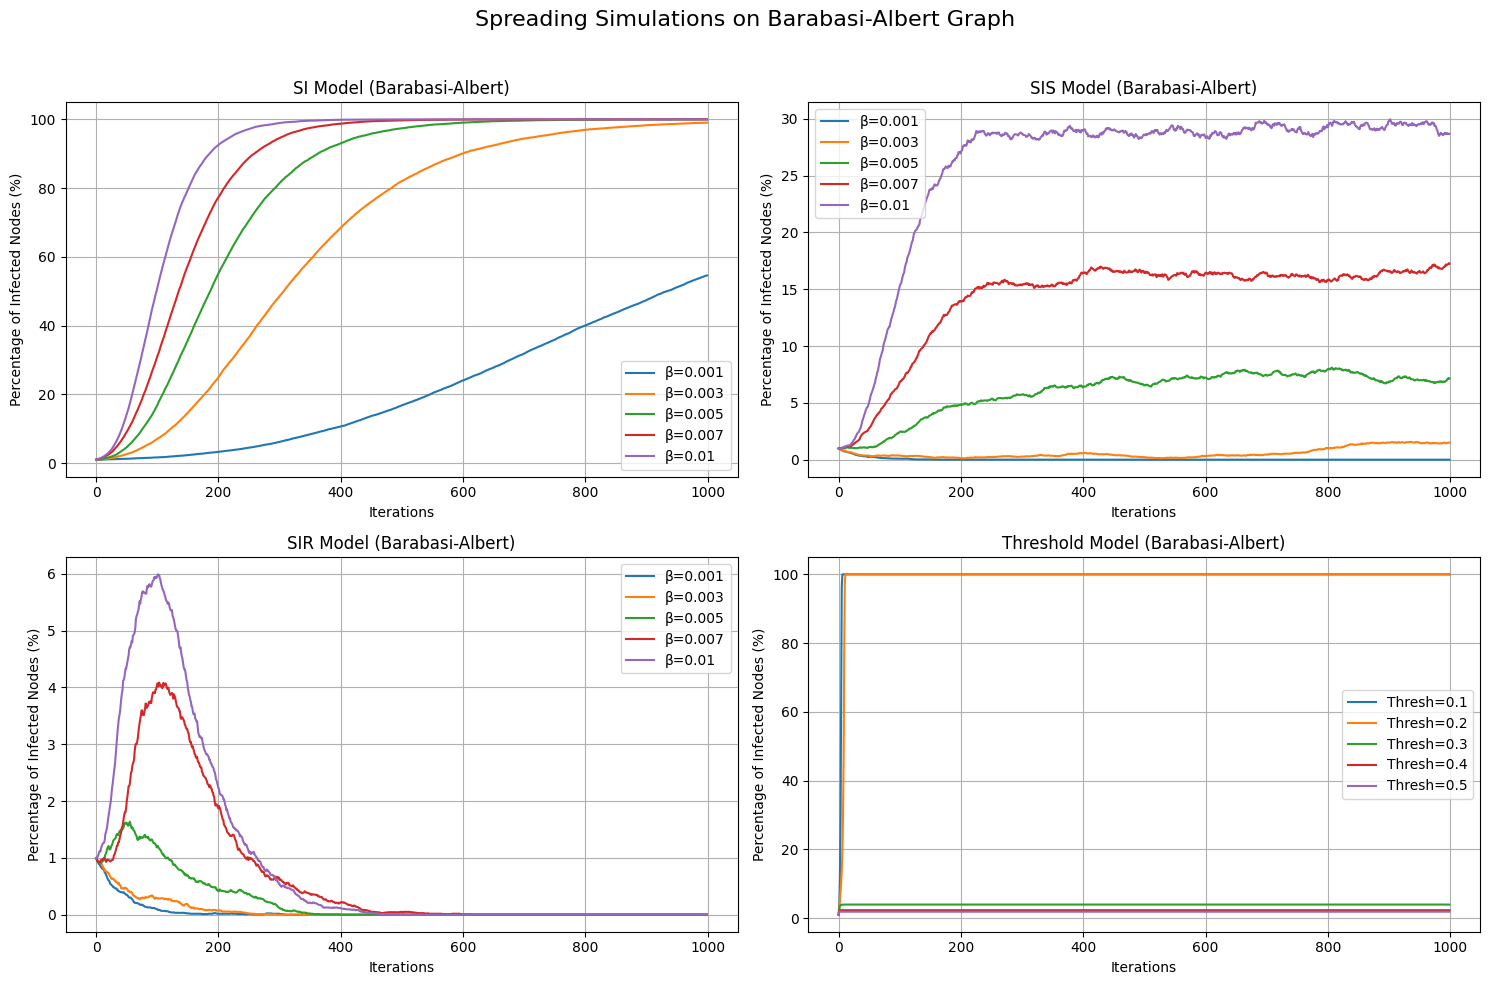


Total execution time: 54.33 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes in the crawled graph
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Extract the Largest Connected Component (LCC)
if nx.is_directed(crawled_graph):
    largest_cc = max(nx.weakly_connected_components(crawled_graph), key=len)  # Weakly connected for directed graphs
else:
    largest_cc = max(nx.connected_components(crawled_graph), key=len)  # Connected for undirected graphs
crawled_graph = crawled_graph.subgraph(largest_cc).copy()

# Define graph parameters
NUM_NODES = len(crawled_graph.nodes)
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES  # Approximate average degree

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Extract LCC for synthetic graphs (since they might be disconnected)
er_graph = er_graph.subgraph(max(nx.connected_components(er_graph), key=len)).copy()
ba_graph = ba_graph.subgraph(max(nx.connected_components(ba_graph), key=len)).copy()

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA_VALUES = [0.001, 0.003, 0.005, 0.007, 0.01]  # Infection rate
GAMMA_VALUES = [0.01, 0.03, 0.05, 0.07, 0.1]  # Recovery rate
THRESHOLD_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5]  # Activation threshold
ITERATIONS = 1000  # Fixed number of iterations

def select_initial_infected(graph, proportion=0.01):
    """Select initial infected nodes based on a percentage of the graph size."""
    num_seeds = max(1, int(proportion * len(graph.nodes)))
    return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)

def simulate_model(graph, model_name, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    """Simulates the given epidemic model on the network and returns infection dynamics."""
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]  # Convert to %
    return infected_counts

def plot_simulation_results(graph_name, model_name, results, ax):
    """Plots infection spread over time with percentage scale."""
    for label, percentages in results.items():
        ax.plot(percentages, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Percentage of Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']

    for idx, model_name in enumerate(models):
        results = {}
        if model_name == 'Threshold':
            for threshold in THRESHOLD_VALUES:
                results[f"Thresh={threshold}"] = simulate_model(graph, model_name, threshold=threshold)
        else:
            for beta in BETA_VALUES:
                gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                results[f"β={beta}"] = simulate_model(graph, model_name, beta=beta, gamma=gamma)

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")


Simulating on Crawled graph...


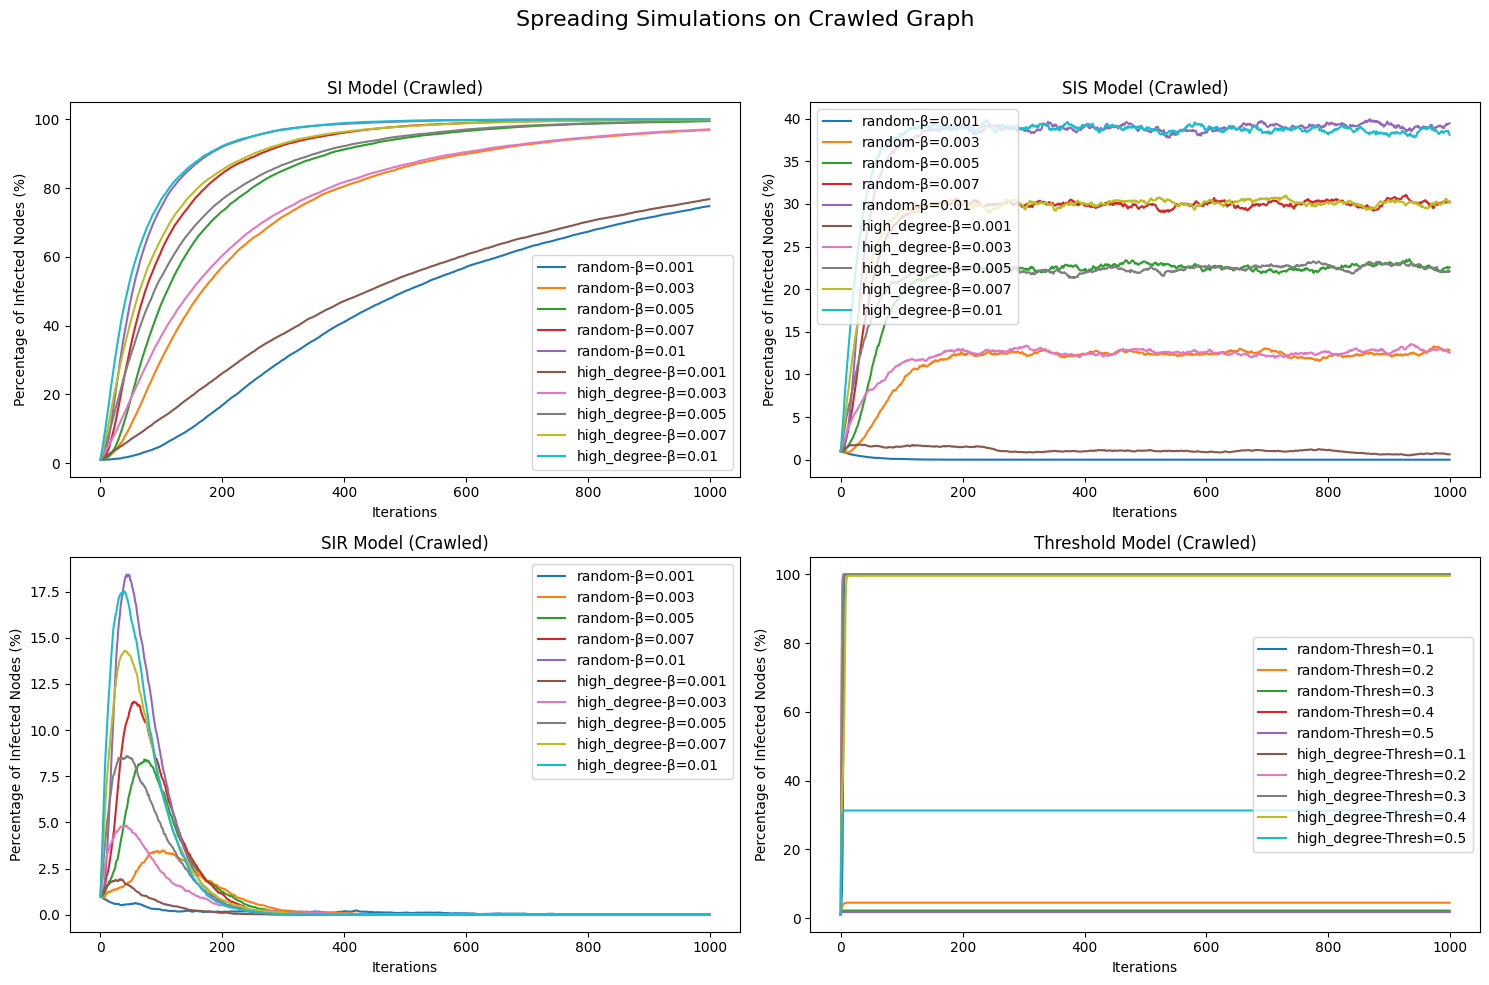

Simulating on Erdos-Renyi graph...


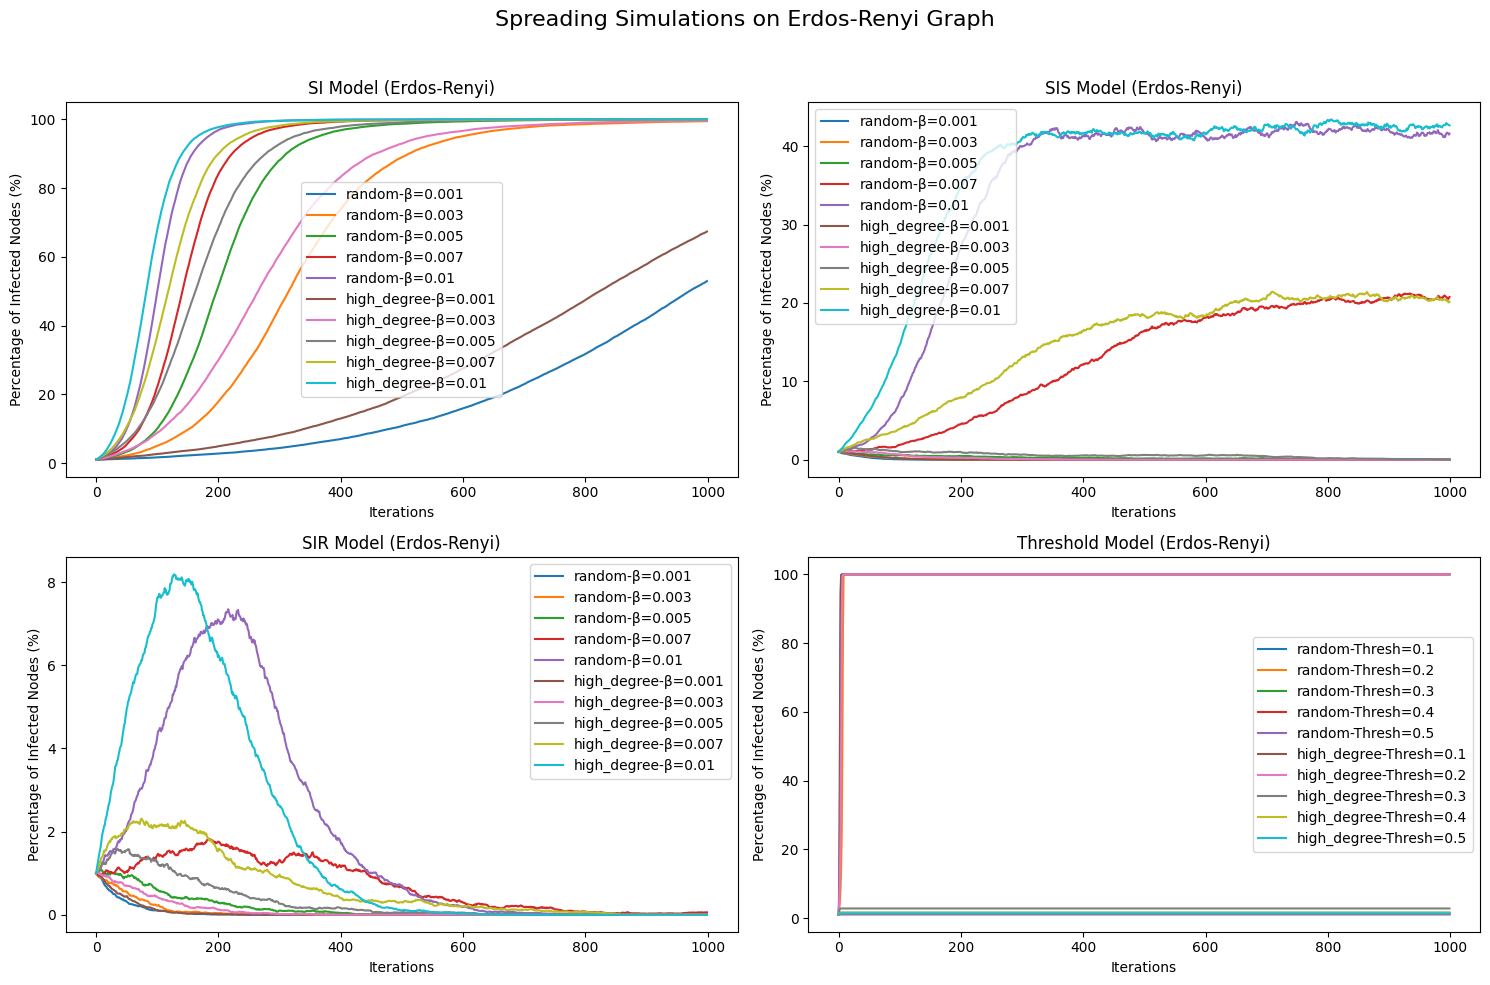

Simulating on Barabasi-Albert graph...


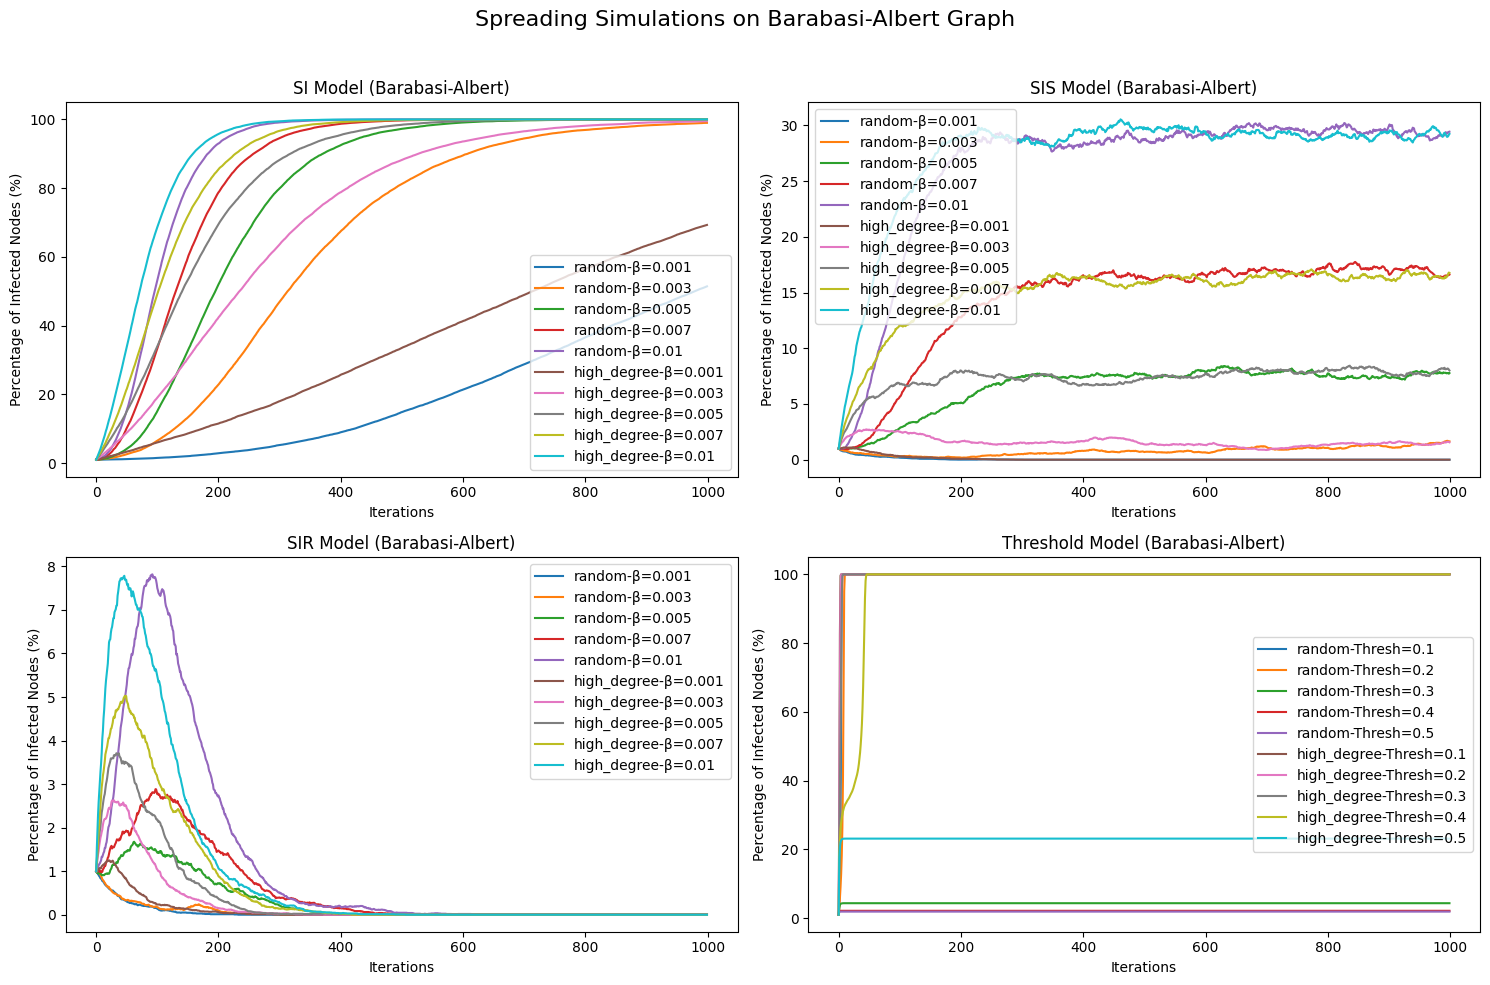


Total execution time: 73.85 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes in the crawled graph
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Extract the Largest Connected Component (LCC)
if nx.is_directed(crawled_graph):
    largest_cc = max(nx.weakly_connected_components(crawled_graph), key=len)
else:
    largest_cc = max(nx.connected_components(crawled_graph), key=len)
crawled_graph = crawled_graph.subgraph(largest_cc).copy()

# Define graph parameters
NUM_NODES = len(crawled_graph.nodes)
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Extract LCC for synthetic graphs
er_graph = er_graph.subgraph(max(nx.connected_components(er_graph), key=len)).copy()
ba_graph = ba_graph.subgraph(max(nx.connected_components(ba_graph), key=len)).copy()

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA_VALUES = [0.001, 0.003, 0.005, 0.007, 0.01]
GAMMA_VALUES = [0.01, 0.03, 0.05, 0.07, 0.1]
THRESHOLD_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5]
ITERATIONS = 1000
SEED_PROPORTION = 0.01  # 1% of nodes as initial seeds

# Seeding Strategies
def select_initial_infected(graph, strategy='random'):
    num_seeds = max(1, int(SEED_PROPORTION * len(graph.nodes)))
    if strategy == 'random':
        return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)
    elif strategy == 'high_degree':
        return [node for node, _ in sorted(graph.degree(), key=lambda x: x[1], reverse=True)[:num_seeds]]
    else:
        raise ValueError("Invalid seed selection strategy.")

# Epidemic Models
def simulate_model(graph, model_name, seed_strategy, beta=None, gamma=None, threshold=None, iterations=ITERATIONS):
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('lambda', gamma)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        if threshold is not None:
            for node in graph.nodes:
                config.add_node_configuration("threshold", node, threshold)

    initial_infected = select_initial_infected(graph, strategy=seed_strategy)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(iterations)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]
    return infected_counts

# Plot results
def plot_simulation_results(graph_name, model_name, results, ax):
    for label, percentages in results.items():
        ax.plot(percentages, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Percentage of Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']
    seeding_strategies = ['random', 'high_degree']

    for idx, model_name in enumerate(models):
        for strategy in seeding_strategies:
            results = {}
            if model_name == 'Threshold':
                for threshold in THRESHOLD_VALUES:
                    results[f"{strategy}-Thresh={threshold}"] = simulate_model(graph, model_name, strategy, threshold=threshold)
            else:
                for beta in BETA_VALUES:
                    gamma = GAMMA_VALUES[1] if model_name in ['SIS', 'SIR'] else None
                    results[f"{strategy}-β={beta}"] = simulate_model(graph, model_name, strategy, beta=beta, gamma=gamma)

            ax = axes[idx // 2, idx % 2]
            plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")



random and hight degree with fixed parameters beta gamma and threshold

Simulating on Crawled graph...


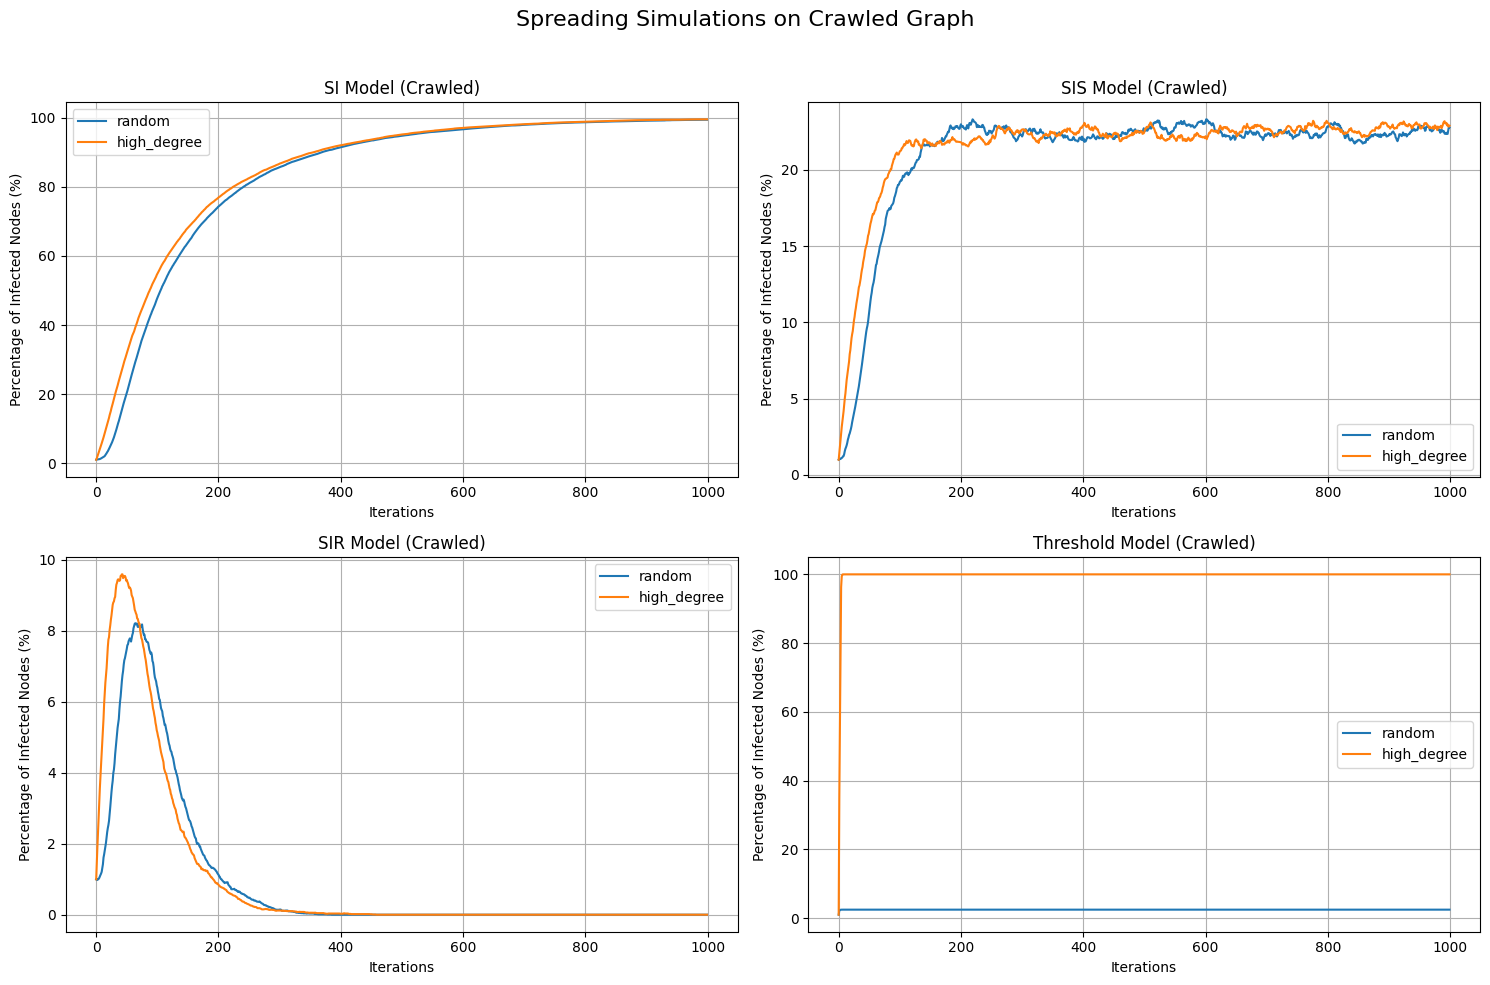

Simulating on Erdos-Renyi graph...


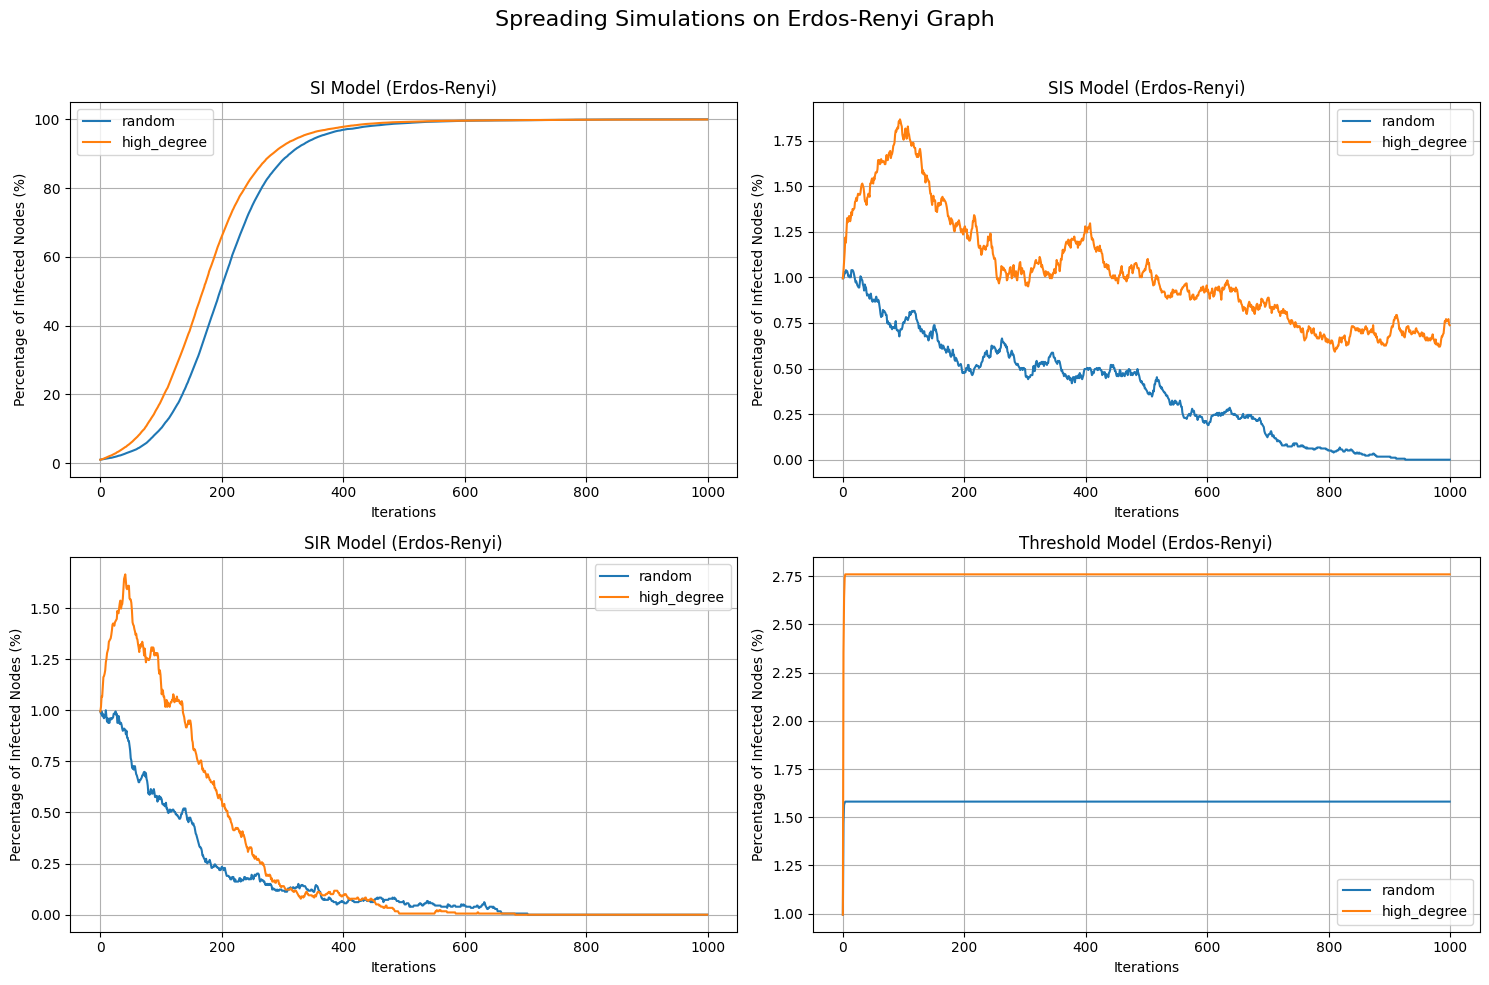

Simulating on Barabasi-Albert graph...


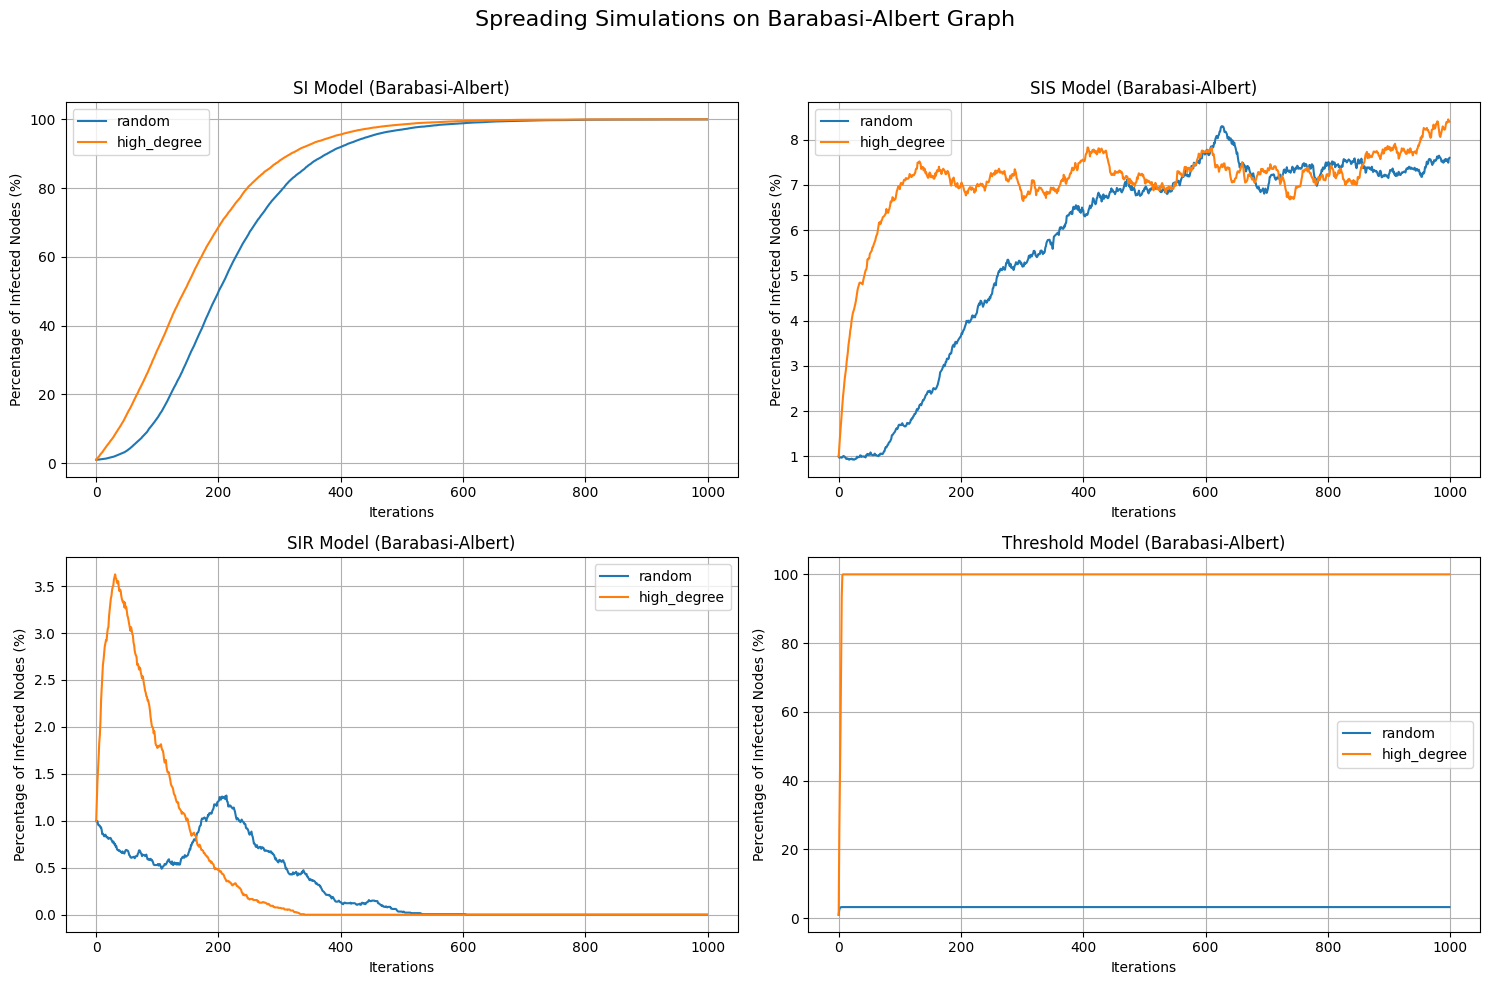


Total execution time: 15.25 minutes


In [ ]:
import time
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np

# Load the crawled network
edgelist_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
crawled_graph = nx.read_edgelist(edgelist_path, delimiter=',', nodetype=str)

# Ensure exactly 19549 nodes in the crawled graph
crawled_graph = crawled_graph.subgraph(list(crawled_graph.nodes)[:19549]).copy()

# Extract the Largest Connected Component (LCC)
if nx.is_directed(crawled_graph):
    largest_cc = max(nx.weakly_connected_components(crawled_graph), key=len)
else:
    largest_cc = max(nx.connected_components(crawled_graph), key=len)
crawled_graph = crawled_graph.subgraph(largest_cc).copy()

# Define graph parameters
NUM_NODES = len(crawled_graph.nodes)
NUM_EDGES = crawled_graph.number_of_edges()
AVG_DEGREE = 2 * NUM_EDGES / NUM_NODES

# Generate Erdős-Rényi and Barabási-Albert graphs
er_graph = nx.gnm_random_graph(NUM_NODES, NUM_EDGES)
ba_graph = nx.barabasi_albert_graph(NUM_NODES, m=max(1, int(AVG_DEGREE / 2)))

# Extract LCC for synthetic graphs
er_graph = er_graph.subgraph(max(nx.connected_components(er_graph), key=len)).copy()
ba_graph = ba_graph.subgraph(max(nx.connected_components(ba_graph), key=len)).copy()

# Store the graphs
graphs = {'Crawled': crawled_graph, 'Erdos-Renyi': er_graph, 'Barabasi-Albert': ba_graph}

# Simulation Parameters
BETA = 0.005  # Infection rate
GAMMA = 0.03  # Recovery rate
THRESHOLD = 0.3  # Activation threshold
ITERATIONS = 1000
SEED_PROPORTION = 0.01  # 1% of nodes as initial seeds

# Seeding Strategies
def select_initial_infected(graph, strategy='random'):
    num_seeds = max(1, int(SEED_PROPORTION * len(graph.nodes)))
    if strategy == 'random':
        return np.random.choice(list(graph.nodes), size=num_seeds, replace=False)
    elif strategy == 'high_degree':
        return [node for node, _ in sorted(graph.degree(), key=lambda x: x[1], reverse=True)[:num_seeds]]
    else:
        raise ValueError("Invalid seed selection strategy.")

# Epidemic Models
def simulate_model(graph, model_name, seed_strategy):
    if model_name == 'SI':
        model = ep.SIModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
    elif model_name == 'SIS':
        model = ep.SISModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
        config.add_model_parameter('lambda', GAMMA)
    elif model_name == 'SIR':
        model = ep.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', BETA)
        config.add_model_parameter('gamma', GAMMA)
    elif model_name == 'Threshold':
        model = ep.ThresholdModel(graph)
        config = mc.Configuration()
        for node in graph.nodes:
            config.add_node_configuration("threshold", node, THRESHOLD)

    initial_infected = select_initial_infected(graph, strategy=seed_strategy)
    config.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(config)

    iterations_data = model.iteration_bunch(ITERATIONS)
    infected_counts = [iteration['node_count'][1] / graph.number_of_nodes() * 100 for iteration in iterations_data]
    return infected_counts

# Plot results
def plot_simulation_results(graph_name, model_name, results, ax):
    for label, percentages in results.items():
        ax.plot(percentages, label=label)
    ax.set_title(f"{model_name} Model ({graph_name})")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Percentage of Infected Nodes (%)')
    ax.legend()
    ax.grid()

# Measure execution time
start_time = time.time()

# Run simulations on each network type
for graph_name, graph in graphs.items():
    print(f"Simulating on {graph_name} graph...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Spreading Simulations on {graph_name} Graph", fontsize=16)

    models = ['SI', 'SIS', 'SIR', 'Threshold']
    seeding_strategies = ['random', 'high_degree']

    for idx, model_name in enumerate(models):
        results = {}
        for strategy in seeding_strategies:
            results[strategy] = simulate_model(graph, model_name, strategy)

        ax = axes[idx // 2, idx % 2]
        plot_simulation_results(graph_name, model_name, results, ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")
